In [1]:
from pickle import dump,load
import numpy as np
import optuna
from keras.models import Sequential
import os
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Dense, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,max_error
import time
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau

2024-07-11 09:20:52.370566: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 09:20:55.162469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.enable_op_determinism()
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True )
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
print(os.getenv('TF_GPU_ALLOCATOR'))

cuda_malloc_async


In [3]:
print("TensorFlow Version:", tf.__version__)
print("CUDA Version:", tf.sysconfig.get_build_info()['cuda_version'])
print("cuDNN Version:", tf.sysconfig.get_build_info()['cudnn_version'])
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow Version: 2.13.1
CUDA Version: 11.8
cuDNN Version: 8
Num GPUs Available:  1


In [4]:
dataset_filtrado_path = 'nuevo_dataset_filtrado.csv'
nuevo_file_path = 'Nivel_Caudal_Asu_Con_1960_2024.csv'
dataset_filtrado = pd.read_csv(dataset_filtrado_path)
nuevo_data = pd.read_csv(nuevo_file_path)
dataset_filtrado['fecha'] = pd.to_datetime(dataset_filtrado['fecha'])
nuevo_data['fecha'] = pd.to_datetime(nuevo_data['fecha'])
columnas_adicionales = ['fecha', 'Qcon', 'Qasu_m']
nuevo_data = nuevo_data[columnas_adicionales]
dataset_combinado = pd.merge(dataset_filtrado, nuevo_data, on='fecha', how='left')
dataset_combinado.info()
dataset_combinado.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19366 entries, 0 to 19365
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   fecha   19366 non-null  datetime64[ns]
 1   e010    19359 non-null  float64       
 2   e134    19351 non-null  float64       
 3   e183    19341 non-null  float64       
 4   e218    19337 non-null  float64       
 5   Qcon    19351 non-null  float64       
 6   Qasu_m  19337 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 1.0 MB


fecha  e010  e134  e183  e218    Qcon  Qasu_m
0 1970-03-14  1.45  1.46  1.19  0.68  1343.6  1350.3
1 1970-03-15  1.45  1.46  1.20  0.73  1343.6  1384.6
2 1970-03-16  1.44  1.46  1.20  0.81  1343.6  1439.1
3 1970-03-17  1.49  1.52  1.25  0.86  1374.0  1472.8
4 1970-03-18  1.49  1.58  1.30  0.86  1404.1  1472.8

In [5]:
dataset_combinado.set_index('fecha',inplace=True)

In [6]:
df_interpolate = dataset_combinado.interpolate(limit = 15, method = 'quadratic', limit_direction = 'both')

In [7]:
df_interpolate.to_csv('df_completo')

In [8]:
df_prueba = pd.read_csv('df_rivers_caudal_1971_07_21_To_2022_11_20.csv')
df_prueba['fecha']= pd.to_datetime(df_prueba['fecha'])
df_prueba.set_index(df_prueba['fecha'],inplace=True)
df_prueba.rename(columns={'valor010':'e010','valor033':'e033','valor088':'e088','valor134':'e134','valor183':'e183','valor211':'e211','e218':'nivel','valor255':'e255'},inplace=True)
df_prueba.drop(columns=['fecha'],inplace=True)
df_prueba['Week_cos'] =  np.cos(2 * np.pi * df_prueba.index.isocalendar().week / 53)
df_prueba['Week_sin'] =  np.sin(2 * np.pi * df_prueba.index.isocalendar().week / 53)

In [9]:
df_prueba

e010  e033  e088  e134  e183  e211  nivel  e255    Qcon  Qasu_m  \
fecha                                                                         
1971-07-21  0.94 -0.18  1.20  1.16  1.16  1.12   1.22  3.08  1189.1  1710.4   
1971-07-22  0.92 -0.19  1.20  1.14  1.12  1.05   1.15  2.95  1178.7  1664.9   
1971-07-23  0.90 -0.20  1.20  1.12  1.10  0.97   1.10  2.85  1168.2  1632.2   
1971-07-24  0.86 -0.21  1.18  1.10  1.04  0.89   1.05  2.74  1157.7  1599.3   
1971-07-25  0.82 -0.22  1.18  1.09  1.02  0.82   1.00  2.65  1152.4  1566.3   
...          ...   ...   ...   ...   ...   ...    ...   ...     ...     ...   
2022-11-16  2.57  2.67  1.55  2.63  3.30  3.28   3.00  4.41  1901.1  2860.6   
2022-11-17  2.57  2.66  1.67  2.85  3.48  3.40   3.13  4.42  1998.0  2950.8   
2022-11-18  2.61  2.65  1.75  3.04  3.58  3.49   3.23  4.42  2079.5  3021.4   
2022-11-19  2.66  2.64  1.77  3.15  3.70  3.58   3.32  4.42  2125.9  3085.8   
2022-11-20  2.66  2.63  1.67  3.16  3.77  3.66   3.40  4.42  2130.1  3144.0   

            Week_cos  Week_sin  
fecha                           
1971-07-21 -0.956401 -0.292057  
1971-07-22 -0.956401 -0.292057  
1971-07-23 -0.956401 -0.292057  
1971-07-24 -0.956401 -0.292057  
1971-07-25 -0.956401 -0.292057  
...              ...       ...  
2022-11-16  0.674983 -0.737833  
2022-11-17  0.674983 -0.737833  
2022-11-18  0.674983 -0.737833  
2022-11-19  0.674983 -0.737833  
2022-11-20  0.674983 -0.737833  

[18751 rows x 12 columns]

In [10]:
#datos_norm = df_interpolate.copy() # Copia del dataframe 
#datos_norm['Week_cos'] =  np.cos(2 * np.pi * datos_norm.index.isocalendar().week / 53)
#datos_norm['Week_sin'] =  np.sin(2 * np.pi * datos_norm.index.isocalendar().week / 53)
#datos_norm['Month'] = datos_norm.index.month
#datos_norm['Month_sin'] = np.sin(2 * np.pi * datos_norm.index.month / 12)
#datos_norm['Month_cos'] = np.cos(2 * np.pi * datos_norm.index.month / 12)
#datos_norm['Year'] = datos_norm.index.year
#datos_norm.rename(columns={'e218':'nivel'},inplace=True)
#horizonte = 28 # Cantidad de días a predecir
#tamanio_ventana = 365 # Datos de niveles de los últimos días para la predición
#cantidad_unidades = 30 # Cantidad de neuronas
#tamanio_batch = 30 # Tamaño del batch
#dropout = 0.25 # Probabilidad para desactivar una neurona
#features_set = 1 # Posición de características para el entrenamiento
#year_ini = 73 # Año inicial
#arch = 'GRU' # Arquictura del modelo
#modelo = arch+'_h'+str(horizonte)+'_w'+str(tamanio_ventana)+'_u'+str(cantidad_unidades)+'_d'+str(dropout)+'_f'+str(features_set)+'_y'+str(year_ini)

In [11]:
#datos_norm.to_csv('df_final')

In [12]:
def preparar_datos(tamanio_ventana,horizonte, data): # Función para la división datos para el entrenamiento
    n_features=len(data.columns)
    x_train = np.zeros((len(data)-tamanio_ventana-horizonte+1,tamanio_ventana, n_features))
    y_train= np.zeros((len(data)-tamanio_ventana-horizonte+1, horizonte ))
    for i in range(tamanio_ventana, len(data)-horizonte +1):
        x_train[(i-tamanio_ventana), :, :] = data.iloc[(i-tamanio_ventana):(i), :]
        y_train[i-tamanio_ventana, :] = data['nivel'].iloc[(i):(i+horizonte)]
    return x_train,y_train

In [13]:
def create_model(trial, tamanio_ventana, cantidad_unidades, nfeatures, dropout, horizonte, lossF):
    model = keras.Sequential()
    model.add(
              tf.keras.layers.Bidirectional(
                                            tf.keras.layers.GRU(
                                                                cantidad_unidades, 
                                                                input_shape=(tamanio_ventana, nfeatures)
                                                                )
                                             )
            )
    model.add(tf.keras.layers.Dropout(rate=dropout))
    model.add(tf.keras.layers.Dense(horizonte))
    model.compile(optimizer='adam', loss=lossF, metrics=[RootMeanSquaredError()])
    return model

In [14]:
orden=['nivel','e010','e033','e088','e134','e183','e211','e255','Qcon','Qasu_m','Week_cos','Week_sin']
datos_norm=df_prueba[orden]
datos_norm.isnull().sum()

nivel       0
e010        0
e033        0
e088        0
e134        0
e183        0
e211        0
e255        0
Qcon        0
Qasu_m      0
Week_cos    0
Week_sin    0
dtype: int64

In [15]:
datos_norm

nivel  e010  e033  e088  e134  e183  e211  e255    Qcon  Qasu_m  \
fecha                                                                         
1971-07-21   1.22  0.94 -0.18  1.20  1.16  1.16  1.12  3.08  1189.1  1710.4   
1971-07-22   1.15  0.92 -0.19  1.20  1.14  1.12  1.05  2.95  1178.7  1664.9   
1971-07-23   1.10  0.90 -0.20  1.20  1.12  1.10  0.97  2.85  1168.2  1632.2   
1971-07-24   1.05  0.86 -0.21  1.18  1.10  1.04  0.89  2.74  1157.7  1599.3   
1971-07-25   1.00  0.82 -0.22  1.18  1.09  1.02  0.82  2.65  1152.4  1566.3   
...           ...   ...   ...   ...   ...   ...   ...   ...     ...     ...   
2022-11-16   3.00  2.57  2.67  1.55  2.63  3.30  3.28  4.41  1901.1  2860.6   
2022-11-17   3.13  2.57  2.66  1.67  2.85  3.48  3.40  4.42  1998.0  2950.8   
2022-11-18   3.23  2.61  2.65  1.75  3.04  3.58  3.49  4.42  2079.5  3021.4   
2022-11-19   3.32  2.66  2.64  1.77  3.15  3.70  3.58  4.42  2125.9  3085.8   
2022-11-20   3.40  2.66  2.63  1.67  3.16  3.77  3.66  4.42  2130.1  3144.0   

            Week_cos  Week_sin  
fecha                           
1971-07-21 -0.956401 -0.292057  
1971-07-22 -0.956401 -0.292057  
1971-07-23 -0.956401 -0.292057  
1971-07-24 -0.956401 -0.292057  
1971-07-25 -0.956401 -0.292057  
...              ...       ...  
2022-11-16  0.674983 -0.737833  
2022-11-17  0.674983 -0.737833  
2022-11-18  0.674983 -0.737833  
2022-11-19  0.674983 -0.737833  
2022-11-20  0.674983 -0.737833  

[18751 rows x 12 columns]

In [16]:
from itertools import combinations
feat = ['e134','e183','e010','Qcon','Qasu_m','Week_cos','Week_sin','Month','Month_sin','Month_cos','Year']
all_combinations = []
for r in range(1, len(feat) + 1):
    combinations_r = combinations(feat, r)
    all_combinations.extend(combinations_r)
all_combinations_as_lists = [list(comb) for comb in all_combinations]
len(all_combinations_as_lists)

2047

In [22]:
def create_objective(datos_norm):
    def objective(trial):
        # Optimización de parámetros
      
        features_set = trial.suggest_categorical('features', [0,1,2])
        
        # Definición de otros parámetros
        year_ini = 73  # Puedes definir o ajustar según tus necesidades
        tamanio_ventana= 365 
        horizonte = 28  # Valor fijo según tu comentario anterior
        cantidad_unidades = 30  # Valor fijo según tu comentario anterior
        tamanio_batch = 256  # Valor fijo según tu comentario anterior
        dropout = 0.25  # Valor fijo según tu comentario anterior
        lossF = 'mean_squared_error'  # Valor fijo según tu comentario anterior
        initial_learning_rate = 0.001  # Valor fijo según tu comentario anterior
        seed = 42
        tf.random.set_seed(seed)
        np.random.seed(seed)
        # Selección de características según features_set
        lista = [   ['nivel', 'e134', 'e183', 'e211', 'e255', 'Qcon','Qasu_m'],
                    ['nivel', 'e134', 'e183', 'e211', 'e255', 'Qcon','Qasu_m','Week_cos','Week_sin'],
                    ['nivel', 'e134', 'e183', 'e211', 'e255', 'Qcon','Qasu_m','Week_cos','Week_sin','e010','e033','e088'],
                ]
        
        datos = datos_norm[lista[features_set]]
        nfeatures = len(datos.columns)
        
        desde = (dt.datetime.strptime('19'+str(year_ini)+'-01-01', '%Y-%m-%d') - dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d')        
        # Normalización de los datos
        Scaler = MinMaxScaler()
        Scaler.fit(datos.loc[desde:'2022-11-20'])
        ix = datos.index
        datos_normm = pd.DataFrame(Scaler.transform(datos), columns=datos.columns)
        datos_normm.set_index(ix, inplace=True)
        
        Rmse = []
        Dtime = []
        maxError = []
        epocash = []
        Error_95 = []
        r2 = []
        hist = []
        
        for valyear in [2017, 2018, 2019]:
            print(f'Validation year: {valyear}')
            
            trainScaled = datos_normm.loc[desde:str(valyear - 1) + '-12-31']
            x_train, y_train = preparar_datos(tamanio_ventana, horizonte, trainScaled)
            
            desde = (dt.datetime.strptime(str(valyear) + '-01-01', '%Y-%m-%d') - dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d')
            valScaled = datos_normm.loc[desde:str(valyear) + '-12-31']
            x_val, y_val = preparar_datos(tamanio_ventana, horizonte, valScaled)
            
            epocas = 10
            
            model = create_model(trial, tamanio_ventana, cantidad_unidades, nfeatures, dropout, horizonte, lossF)
            
            early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
            lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
            callbacks_list = [early_stopping, lr_scheduler]
            
            start_time = time.time()
            model.reset_states()
            
            history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epocas, batch_size=tamanio_batch, verbose=1, callbacks=callbacks_list)
            
            Y_prediction = Scaler.inverse_transform(np.hstack(((model.predict(x_val).reshape(-1, 1), np.zeros((np.size(y_val), nfeatures - 1))))))[:, 0]
            y_val_inv = Scaler.inverse_transform(np.hstack(((y_val.reshape(-1, 1), np.zeros((np.size(y_val), nfeatures - 1))))))[:, 0]
            
            mse = mean_squared_error(y_val_inv, Y_prediction)
            rmse = np.sqrt(mse)
            error = np.abs(y_val_inv - Y_prediction)
            Error_95_ = np.percentile(error, 95)
            maxError_ = max_error(y_val_inv, Y_prediction)
            r2_ = r2_score(y_val_inv, Y_prediction)
            
            print(f"MSE: {mse} RMSE: {rmse}")
            print(f"MaxError: {maxError_} R2: {r2_} Error95: {Error_95_}")
            
            end_time = time.time()
            elapsed_time = end_time - start_time
            print(f"Time step: {elapsed_time:.6f} seconds")
            
            Rmse.append(rmse)
            Dtime.append(elapsed_time)
            maxError.append(maxError_)
            Error_95.append(Error_95_)
            epocash.append(len(history.history['loss']))
            r2.append(r2_)
            hist.append(history)
            
            if len(history.history['loss']) < epocas * 0.2:
                continue
        
        avg_score = np.mean(Rmse)
        avg_Error_95 = np.mean(Error_95)
        
        print(f"Avg RMSE: {avg_score}, Avg Error95: {avg_Error_95}")
        
        trial.set_user_attr("mean_rmse", avg_score)
        trial.set_user_attr("Error95_mean", avg_Error_95)
        
        return avg_score, avg_Error_95

    return objective

In [23]:
SEED = 42
study =optuna.create_study(directions=['minimize','minimize'],sampler=optuna.samplers.TPESampler(seed=SEED))
objective = create_objective(datos_norm)

[I 2024-07-11 09:24:37,795] A new study created in memory with name: no-name-bd3a4220-9268-4e97-b864-806d150746c1


In [24]:
study.optimize(objective, n_trials=100, n_jobs=2)

Validation year: 2017
Validation year: 2017
Epoch 1/10
Epoch 1/10
63/63 [==============================] - 20s 160ms/step - loss: 0.0966 - root_mean_squared_error: 0.3108 - val_loss: 0.0161 - val_root_mean_squared_error: 0.1269 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 20s 161ms/step - loss: 0.0750 - root_mean_squared_error: 0.2739 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1077 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 7s 113ms/step - loss: 0.0234 - root_mean_squared_error: 0.1531 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0857 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 7s 113ms/step - loss: 0.0182 - root_mean_squared_error: 0.1350 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0788 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 7s 107ms/step - loss: 0.0151 - root_mean_squared_error: 0.1228 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0711 - lr: 0.0010
Epoch 4/10
63/63 [

[I 2024-07-11 09:26:55,102] Trial 0 finished with values: [2.1372867001213898, 3.9830352998773257] and parameters: {'features': 1}. 


MSE: 7.1615283300959645 RMSE: 2.6761031987006714
MaxError: 7.126002540588379 R2: -0.43852801095946026 Error95: 5.246086499094964
Time step: 19.828351 seconds
Avg RMSE: 2.1372867001213898, Avg Error95: 3.9830352998773257
MSE: 6.450923653573639 RMSE: 2.539866857450138
MaxError: 7.740755815505981 R2: -0.29578966171628207 Error95: 5.171424926042558
Time step: 19.588191 seconds
Avg RMSE: 1.9346413896300305, Avg Error95: 3.720455875794093


[I 2024-07-11 09:26:55,216] Trial 1 finished with values: [1.9346413896300305, 3.720455875794093] and parameters: {'features': 0}. 


Validation year: 2017
Validation year: 2017
Epoch 1/10
Epoch 1/10
63/63 [==============================] - 18s 123ms/step - loss: 0.0747 - root_mean_squared_error: 0.2733 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1051 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 19s 129ms/step - loss: 0.0810 - root_mean_squared_error: 0.2846 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1099 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 6s 103ms/step - loss: 0.0183 - root_mean_squared_error: 0.1351 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 7s 105ms/step - loss: 0.0210 - root_mean_squared_error: 0.1447 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0756 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 8s 127ms/step - loss: 0.0127 - root_mean_squared_error: 0.1128 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0731 - lr: 0.0010
Epoch 4/10
63/63 [

[I 2024-07-11 09:29:08,742] Trial 2 finished with values: [2.1626617762304208, 4.291158134281637] and parameters: {'features': 1}. 


MSE: 9.862704221578873 RMSE: 3.140494263898419
MaxError: 11.547783508300782 R2: -0.9811101251845793 Error95: 6.623737540960312
Time step: 17.694214 seconds
Avg RMSE: 2.1626617762304208, Avg Error95: 4.291158134281637
11/11 [==============================] - 2s 59ms/step
Validation year: 2017


[I 2024-07-11 09:29:08,922] Trial 3 finished with values: [1.935256381079519, 3.716269827961922] and parameters: {'features': 0}. 


MSE: 7.545994624828363 RMSE: 2.746997383476796
MaxError: 9.319068397283553 R2: -0.5157553161867705 Error95: 5.454562240600586
Time step: 17.763923 seconds
Avg RMSE: 1.935256381079519, Avg Error95: 3.716269827961922
Validation year: 2017
Epoch 1/10
Epoch 1/10
63/63 [==============================] - 15s 106ms/step - loss: 0.0636 - root_mean_squared_error: 0.2522 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1196 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 17s 117ms/step - loss: 0.0944 - root_mean_squared_error: 0.3072 - val_loss: 0.0161 - val_root_mean_squared_error: 0.1270 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 7s 116ms/step - loss: 0.0203 - root_mean_squared_error: 0.1425 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0855 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 7s 104ms/step - loss: 0.0254 - root_mean_squared_error: 0.1595 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849 - lr: 0.0010
Epoch 3/10

[I 2024-07-11 09:31:22,937] Trial 5 finished with values: [2.0357809261606836, 4.051484726369382] and parameters: {'features': 2}. 


MSE: 7.587501018510362 RMSE: 2.754541889046228
MaxError: 7.4545793533325195 R2: -0.5240926580491974 Error95: 5.65342326706648
Time step: 20.329927 seconds
Avg RMSE: 2.0357809261606836, Avg Error95: 4.051484726369382
11/11 [==============================] - 3s 59ms/step
Validation year: 2017


[I 2024-07-11 09:31:23,116] Trial 4 finished with values: [1.9178288177139524, 3.8382434021631884] and parameters: {'features': 1}. 


MSE: 7.760101987381368 RMSE: 2.78569596104481
MaxError: 7.476804418563843 R2: -0.5587628174055812 Error95: 5.724549627542497
Time step: 20.814285 seconds
Avg RMSE: 1.9178288177139524, Avg Error95: 3.8382434021631884
Validation year: 2017
Epoch 1/10
Epoch 1/10
63/63 [==============================] - 19s 134ms/step - loss: 0.0669 - root_mean_squared_error: 0.2586 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1072 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 20s 137ms/step - loss: 0.0857 - root_mean_squared_error: 0.2928 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1017 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 7s 108ms/step - loss: 0.0176 - root_mean_squared_error: 0.1325 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0794 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 7s 108ms/step - loss: 0.0225 - root_mean_squared_error: 0.1500 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0745 - lr: 0.0010
Epoch 3/1

[I 2024-07-11 09:33:42,175] Trial 7 finished with values: [1.9216570271987863, 3.5864475586414337] and parameters: {'features': 0}. 


MSE: 7.929369995056146 RMSE: 2.8159137051863197
MaxError: 8.252346312701702 R2: -0.5927634886556252 Error95: 5.394042310118676
Time step: 18.343776 seconds
Avg RMSE: 1.9216570271987863, Avg Error95: 3.5864475586414337
Validation year: 2017
11/11 [==============================] - 1s 17ms/step


[I 2024-07-11 09:33:42,626] Trial 6 finished with values: [2.0922238481185866, 4.014906499912342] and parameters: {'features': 2}. 


MSE: 6.633628614392775 RMSE: 2.5755831600615764
MaxError: 7.320165609121323 R2: -0.33248939838772196 Error95: 5.179468261718749
Time step: 18.642268 seconds
Avg RMSE: 2.0922238481185866, Avg Error95: 4.014906499912342
Validation year: 2017
Epoch 1/10
Epoch 1/10
63/63 [==============================] - 18s 121ms/step - loss: 0.0600 - root_mean_squared_error: 0.2450 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0973 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 18s 120ms/step - loss: 0.0726 - root_mean_squared_error: 0.2694 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1351 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 7s 107ms/step - loss: 0.0174 - root_mean_squared_error: 0.1321 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0801 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 7s 109ms/step - loss: 0.0206 - root_mean_squared_error: 0.1436 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0854 - lr: 0.0010
Epoch 3

[I 2024-07-11 09:35:53,474] Trial 9 finished with values: [2.084761674051877, 3.913842096095284] and parameters: {'features': 1}. 


MSE: 6.116665373195201 RMSE: 2.473189312041276
MaxError: 7.252552757263183 R2: -0.22864758295094112 Error95: 4.737796164155006
Time step: 17.858031 seconds
Avg RMSE: 2.084761674051877, Avg Error95: 3.913842096095284
Validation year: 2017
11/11 [==============================] - 2s 40ms/step


[I 2024-07-11 09:35:54,894] Trial 8 finished with values: [1.9264863068186218, 3.3180683002471922] and parameters: {'features': 0}. 


MSE: 6.254280177392265 RMSE: 2.5008558889692676
MaxError: 10.69515100479126 R2: -0.2562901113939622 Error95: 4.425510937690735
Time step: 18.293736 seconds
Avg RMSE: 1.9264863068186218, Avg Error95: 3.3180683002471922
Validation year: 2017
Epoch 1/10
Epoch 1/10
63/63 [==============================] - 15s 116ms/step - loss: 0.0856 - root_mean_squared_error: 0.2925 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1258 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 14s 119ms/step - loss: 0.0844 - root_mean_squared_error: 0.2905 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1039 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 7s 119ms/step - loss: 0.0204 - root_mean_squared_error: 0.1428 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0919 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 6s 102ms/step - loss: 0.0178 - root_mean_squared_error: 0.1334 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0747 - lr: 0.0010
Epoch 3

[I 2024-07-11 09:38:06,248] Trial 10 finished with values: [2.033996802395695, 4.005753401488067] and parameters: {'features': 0}. 


MSE: 6.8809567708529915 RMSE: 2.6231577861144744
MaxError: 9.107718789577484 R2: -0.38216992251157444 Error95: 5.567275056242944
Time step: 21.226186 seconds
Avg RMSE: 2.033996802395695, Avg Error95: 4.005753401488067
11/11 [==============================] - 3s 64ms/step
Validation year: 2017


[I 2024-07-11 09:38:06,436] Trial 11 finished with values: [1.9759649209522283, 3.9271817409594862] and parameters: {'features': 0}. 


MSE: 8.617094245617468 RMSE: 2.935488757535526
MaxError: 10.060578637123108 R2: -0.7309058728854041 Error95: 6.067992871999741
Time step: 21.202031 seconds
Avg RMSE: 1.9759649209522283, Avg Error95: 3.9271817409594862
Validation year: 2017
Epoch 1/10
Epoch 1/10
63/63 [==============================] - 20s 138ms/step - loss: 0.1119 - root_mean_squared_error: 0.3345 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1369 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 20s 139ms/step - loss: 0.0710 - root_mean_squared_error: 0.2665 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1098 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 7s 107ms/step - loss: 0.0221 - root_mean_squared_error: 0.1487 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1013 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 7s 109ms/step - loss: 0.0169 - root_mean_squared_error: 0.1302 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0798 - lr: 0.0010
Epoch 3

[I 2024-07-11 09:40:22,139] Trial 12 finished with values: [2.2294285474718762, 4.036691981832186] and parameters: {'features': 0}. 


MSE: 7.398065714347167 RMSE: 2.7199385497373223
MaxError: 10.205361425876617 R2: -0.48604100500215464 Error95: 5.59827984714508
Time step: 16.736836 seconds
Avg RMSE: 2.2294285474718762, Avg Error95: 4.036691981832186
Validation year: 2017
11/11 [==============================] - 1s 16ms/step


[I 2024-07-11 09:40:23,069] Trial 13 finished with values: [2.00640550678259, 3.8843926230470345] and parameters: {'features': 0}. 


MSE: 6.941541815255689 RMSE: 2.634680590746379
MaxError: 8.908586149811745 R2: -0.394339571139821 Error95: 5.469582445979119
Time step: 16.776619 seconds
Avg RMSE: 2.00640550678259, Avg Error95: 3.8843926230470345
Validation year: 2017
Epoch 1/10
Epoch 1/10
63/63 [==============================] - 17s 116ms/step - loss: 0.0741 - root_mean_squared_error: 0.2722 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1091 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 16s 120ms/step - loss: 0.0847 - root_mean_squared_error: 0.2910 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1237 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 7s 103ms/step - loss: 0.0200 - root_mean_squared_error: 0.1415 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0748 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 7s 108ms/step - loss: 0.0219 - root_mean_squared_error: 0.1479 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0820 - lr: 0.0010
Epoch 3/10


[I 2024-07-11 09:42:39,091] Trial 14 finished with values: [2.006093501350549, 3.707475533723832] and parameters: {'features': 2}. 


MSE: 5.301828285922282 RMSE: 2.3025699307344136
MaxError: 7.599478757381439 R2: -0.06497218848454733 Error95: 4.580770620346069
Time step: 17.265445 seconds
Avg RMSE: 2.006093501350549, Avg Error95: 3.707475533723832
Validation year: 2017
11/11 [==============================] - 1s 17ms/step


[I 2024-07-11 09:42:39,535] Trial 15 finished with values: [1.8734051020117706, 3.4451178907155993] and parameters: {'features': 2}. 


MSE: 6.391798131096479 RMSE: 2.5282005717696685
MaxError: 7.990988760590554 R2: -0.2839131855891719 Error95: 4.914450716495516
Time step: 17.239815 seconds
Avg RMSE: 1.8734051020117706, Avg Error95: 3.4451178907155993
Validation year: 2017
Epoch 1/10
Epoch 1/10
63/63 [==============================] - 20s 137ms/step - loss: 0.0696 - root_mean_squared_error: 0.2637 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1029 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 20s 137ms/step - loss: 0.0691 - root_mean_squared_error: 0.2629 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1099 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 7s 109ms/step - loss: 0.0181 - root_mean_squared_error: 0.1345 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0823 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 7s 109ms/step - loss: 0.0212 - root_mean_squared_error: 0.1455 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0800 - lr: 0.0010
Epoch 3

[I 2024-07-11 09:45:01,640] Trial 16 finished with values: [2.326380354625833, 4.357980743189653] and parameters: {'features': 0}. 


MSE: 6.569131753807804 RMSE: 2.563031750448637
MaxError: 8.762228502035141 R2: -0.31953398771364516 Error95: 5.638895991206169
Time step: 19.117677 seconds
Avg RMSE: 2.326380354625833, Avg Error95: 4.357980743189653
Validation year: 2017
11/11 [==============================] - 3s 15ms/step


[I 2024-07-11 09:45:02,042] Trial 17 finished with values: [2.106782273825177, 4.010649287561576] and parameters: {'features': 2}. 


MSE: 7.6470289341588265 RMSE: 2.76532618946822
MaxError: 7.000441164970398 R2: -0.5360499624327437 Error95: 5.44271143770218
Time step: 19.571887 seconds
Avg RMSE: 2.106782273825177, Avg Error95: 4.010649287561576
Validation year: 2017
Epoch 1/10
Epoch 1/10
63/63 [==============================] - 19s 144ms/step - loss: 0.0762 - root_mean_squared_error: 0.2760 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1139 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 19s 146ms/step - loss: 0.0930 - root_mean_squared_error: 0.3049 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1149 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 5s 77ms/step - loss: 0.0260 - root_mean_squared_error: 0.1612 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0828 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 5s 78ms/step - loss: 0.0220 - root_mean_squared_error: 0.1483 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0768 - lr: 0.0010
Epoch 3/10
63

[I 2024-07-11 09:46:52,704] Trial 18 finished with values: [1.972965672453955, 3.7862347367256874] and parameters: {'features': 2}. 


MSE: 7.30611218578577 RMSE: 2.702982091280993
MaxError: 6.784337155818939 R2: -0.4675704048110976 Error95: 5.286931131362915
Time step: 13.698543 seconds
Avg RMSE: 1.972965672453955, Avg Error95: 3.7862347367256874
Validation year: 2017
11/11 [==============================] - 1s 14ms/step


[I 2024-07-11 09:46:53,987] Trial 19 finished with values: [2.1263657372304117, 4.0203333102266] and parameters: {'features': 2}. 


MSE: 7.8864571307064875 RMSE: 2.8082836627923626
MaxError: 8.090833957791329 R2: -0.5841436306376007 Error95: 5.555256126403808
Time step: 14.075053 seconds
Avg RMSE: 2.1263657372304117, Avg Error95: 4.0203333102266
Validation year: 2017
Epoch 1/10
Epoch 1/10
63/63 [==============================] - 14s 90ms/step - loss: 0.0679 - root_mean_squared_error: 0.2605 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1277 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 14s 90ms/step - loss: 0.1116 - root_mean_squared_error: 0.3341 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 3s 53ms/step - loss: 0.0226 - root_mean_squared_error: 0.1504 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0931 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 3s 53ms/step - loss: 0.0248 - root_mean_squared_error: 0.1574 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0778 - lr: 0.0010
Epoch 3/10
63

[I 2024-07-11 09:48:15,491] Trial 21 finished with values: [1.8984482025390736, 3.6163151435852057] and parameters: {'features': 2}. 


MSE: 7.966890697684658 RMSE: 2.8225681032854917
MaxError: 8.618999652862549 R2: -0.6003002293112711 Error95: 5.496969948291779
Time step: 11.354277 seconds
Avg RMSE: 1.8984482025390736, Avg Error95: 3.6163151435852057
Validation year: 2017
11/11 [==============================] - 1s 15ms/step


[I 2024-07-11 09:48:16,132] Trial 20 finished with values: [1.9280847746123257, 3.7315573111375193] and parameters: {'features': 2}. 


MSE: 7.355128033563634 RMSE: 2.7120339292795794
MaxError: 7.258398008346557 R2: -0.4774161621354196 Error95: 5.263115057706835
Time step: 11.095420 seconds
Avg RMSE: 1.9280847746123257, Avg Error95: 3.7315573111375193
Validation year: 2017
Epoch 1/10
Epoch 1/10
63/63 [==============================] - 12s 69ms/step - loss: 0.0696 - root_mean_squared_error: 0.2639 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1096 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 14s 77ms/step - loss: 0.0825 - root_mean_squared_error: 0.2873 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1321 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 3s 47ms/step - loss: 0.0207 - root_mean_squared_error: 0.1437 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0775 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 3s 52ms/step - loss: 0.0203 - root_mean_squared_error: 0.1425 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0927 - lr: 0.0010
Epoch 3/10


[I 2024-07-11 09:49:29,269] Trial 22 finished with values: [1.941699084949544, 3.849951069821915] and parameters: {'features': 2}. 


MSE: 7.504255831518483 RMSE: 2.7393896823048896
MaxError: 7.903730335235596 R2: -0.507371292476694 Error95: 5.445851256817581
Time step: 10.488934 seconds
Avg RMSE: 1.941699084949544, Avg Error95: 3.849951069821915
2/2 [==============================] - 0s 408ms/step - loss: 0.2581 - root_mean_squared_error: 0.5080 - val_loss: 0.1600 - val_root_mean_squared_error: 0.4000 - lr: 0.0010
Epoch 7/10
2/2 [==============================] - 1s 103ms/step - loss: 0.2212 - root_mean_squared_error: 0.4703 - val_loss: 0.1376 - val_root_mean_squared_error: 0.3709 - lr: 0.0010
Epoch 8/10
2/2 [==============================] - 0s 107ms/step - loss: 0.1898 - root_mean_squared_error: 0.4357 - val_loss: 0.1195 - val_root_mean_squared_error: 0.3457 - lr: 0.0010
Epoch 9/10
2/2 [==============================] - 0s 111ms/step - loss: 0.1634 - root_mean_squared_error: 0.4042 - val_loss: 0.1060 - val_root_mean_squared_error: 0.3255 - lr: 0.0010
Epoch 10/10
11/11 [==============================] - 1s 16ms/ste

[I 2024-07-11 09:49:31,926] Trial 23 finished with values: [2.233665760635074, 4.365947206631304] and parameters: {'features': 0}. 


MSE: 9.220516070889078 RMSE: 3.0365302683966577
MaxError: 9.757763693332672 R2: -0.8521145252940812 Error95: 6.0571852286011
Time step: 9.827569 seconds
Avg RMSE: 2.233665760635074, Avg Error95: 4.365947206631304
Validation year: 2017
Epoch 1/10
Epoch 1/10
63/63 [==============================] - 10s 48ms/step - loss: 0.0835 - root_mean_squared_error: 0.2890 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1259 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 3s 51ms/step - loss: 0.0211 - root_mean_squared_error: 0.1451 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0900 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 8s 62ms/step - loss: 0.0833 - root_mean_squared_error: 0.2886 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1051 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 3s 51ms/step - loss: 0.0140 - root_mean_squared_error: 0.1181 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0720 - lr: 0.0010
Epoch 4/10
63/63 

[I 2024-07-11 09:50:36,958] Trial 24 finished with values: [2.2939351068682865, 4.3904542726278315] and parameters: {'features': 0}. 


MSE: 10.410777374466157 RMSE: 3.2265736276220567
MaxError: 9.468905930519105 R2: -1.0912009530278395 Error95: 7.115240935087206
Time step: 10.181680 seconds
Avg RMSE: 2.2939351068682865, Avg Error95: 4.3904542726278315
Validation year: 2017
2/2 [==============================] - 7s 1s/step - loss: 0.3986 - root_mean_squared_error: 0.6313 - val_loss: 0.2789 - val_root_mean_squared_error: 0.5281 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 0s 103ms/step - loss: 0.3543 - root_mean_squared_error: 0.5952 - val_loss: 0.2436 - val_root_mean_squared_error: 0.4935 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 106ms/step - loss: 0.3137 - root_mean_squared_error: 0.5601 - val_loss: 0.2121 - val_root_mean_squared_error: 0.4606 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 123ms/step - loss: 0.2771 - root_mean_squared_error: 0.5264 - val_loss: 0.1840 - val_root_mean_squared_error: 0.4290 - lr: 0.0010
Epoch 5/10
2/2 [=========================

[I 2024-07-11 09:50:44,391] Trial 25 finished with values: [2.3778308330424367, 4.419655900880695] and parameters: {'features': 0}. 


MSE: 7.826615061349135 RMSE: 2.797608811351068
MaxError: 9.618090786933898 R2: -0.5721232225575872 Error95: 5.621488669395448
Time step: 10.011596 seconds
Avg RMSE: 2.3778308330424367, Avg Error95: 4.419655900880695
Validation year: 2017
63/63 [==============================] - 10s 59ms/step - loss: 0.0808 - root_mean_squared_error: 0.2842 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1212 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 2s 35ms/step - loss: 0.0211 - root_mean_squared_error: 0.1453 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0840 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 3s 47ms/step - loss: 0.0140 - root_mean_squared_error: 0.1182 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0712 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 9s 64ms/step - loss: 0.0729 - root_mean_squared_error: 0.2701 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1084 - lr: 0.0010
Epoch 2/10
63/63 [==================

[I 2024-07-11 09:51:44,053] Trial 26 finished with values: [2.2404544677240046, 4.19015293760598] and parameters: {'features': 1}. 


MSE: 9.467335315424695 RMSE: 3.076903527155945
MaxError: 10.804681673049927 R2: -0.9016928248612603 Error95: 5.984023322939874
Time step: 10.468144 seconds
Avg RMSE: 2.2404544677240046, Avg Error95: 4.19015293760598
Validation year: 2017
2/2 [==============================] - 4s 806ms/step - loss: 0.4673 - root_mean_squared_error: 0.6836 - val_loss: 0.3436 - val_root_mean_squared_error: 0.5861 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 1s 103ms/step - loss: 0.4052 - root_mean_squared_error: 0.6365 - val_loss: 0.2937 - val_root_mean_squared_error: 0.5420 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 103ms/step - loss: 0.3504 - root_mean_squared_error: 0.5919 - val_loss: 0.2504 - val_root_mean_squared_error: 0.5004 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 115ms/step - loss: 0.3047 - root_mean_squared_error: 0.5520 - val_loss: 0.2128 - val_root_mean_squared_error: 0.4614 - lr: 0.0010
Epoch 5/10
2/2 [=========================

[I 2024-07-11 09:51:47,697] Trial 27 finished with values: [2.0462429039660095, 3.9512059802214297] and parameters: {'features': 1}. 


MSE: 7.558684149065471 RMSE: 2.7493061213814425
MaxError: 12.212014598846435 R2: -0.518304246417782 Error95: 5.403627861618995
Time step: 7.760941 seconds
Avg RMSE: 2.0462429039660095, Avg Error95: 3.9512059802214297
Validation year: 2017
Epoch 1/10
Epoch 1/10
63/63 [==============================] - 10s 69ms/step - loss: 0.0849 - root_mean_squared_error: 0.2913 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1047 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 2s 33ms/step - loss: 0.0227 - root_mean_squared_error: 0.1507 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0723 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 3s 52ms/step - loss: 0.0147 - root_mean_squared_error: 0.1212 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0611 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 11s 68ms/step - loss: 0.0711 - root_mean_squared_error: 0.2666 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1195 - lr: 0.0010
Epoch 2/10
6

[I 2024-07-11 09:52:52,287] Trial 28 finished with values: [1.9699029708428224, 3.6037741702397668] and parameters: {'features': 2}. 


MSE: 4.824914038901648 RMSE: 2.1965686966042397
MaxError: 5.714919576644897 R2: 0.030825031262767255 Error95: 4.173327530384064
Time step: 10.318441 seconds
Avg RMSE: 1.9699029708428224, Avg Error95: 3.6037741702397668
Validation year: 2017
2/2 [==============================] - 6s 1s/step - loss: 0.4348 - root_mean_squared_error: 0.6594 - val_loss: 0.3046 - val_root_mean_squared_error: 0.5519 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 0s 108ms/step - loss: 0.3673 - root_mean_squared_error: 0.6061 - val_loss: 0.2536 - val_root_mean_squared_error: 0.5036 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 106ms/step - loss: 0.3110 - root_mean_squared_error: 0.5576 - val_loss: 0.2112 - val_root_mean_squared_error: 0.4596 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 123ms/step - loss: 0.2617 - root_mean_squared_error: 0.5115 - val_loss: 0.1760 - val_root_mean_squared_error: 0.4196 - lr: 0.0010
Epoch 5/10
2/2 [=========================

[I 2024-07-11 09:52:59,208] Trial 29 finished with values: [2.1058540558056422, 4.024307948927085] and parameters: {'features': 2}. 


MSE: 6.82379001969427 RMSE: 2.612238507428881
MaxError: 8.441105686426162 R2: -0.370686902540575 Error95: 5.178295805633068
Time step: 11.452842 seconds
Avg RMSE: 2.1058540558056422, Avg Error95: 4.024307948927085
Validation year: 2017
63/63 [==============================] - 13s 61ms/step - loss: 0.0688 - root_mean_squared_error: 0.2622 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 3s 54ms/step - loss: 0.0215 - root_mean_squared_error: 0.1465 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0797 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 8s 56ms/step - loss: 0.0641 - root_mean_squared_error: 0.2532 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1076 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 3s 48ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0697 - lr: 0.0010
Epoch 4/10
63/63 [====================

[I 2024-07-11 09:54:02,366] Trial 30 finished with values: [2.2037269290886417, 4.283322198033333] and parameters: {'features': 2}. 


MSE: 11.140714893431609 RMSE: 3.3377709468193903
MaxError: 11.02550661087036 R2: -1.2378226682376128 Error95: 6.70512870335579
Time step: 9.504585 seconds
Avg RMSE: 2.2037269290886417, Avg Error95: 4.283322198033333
Validation year: 2017
2/2 [==============================] - 7s 3s/step - loss: 0.3852 - root_mean_squared_error: 0.6207 - val_loss: 0.2776 - val_root_mean_squared_error: 0.5269 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 0s 114ms/step - loss: 0.3410 - root_mean_squared_error: 0.5840 - val_loss: 0.2390 - val_root_mean_squared_error: 0.4889 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 125ms/step - loss: 0.2997 - root_mean_squared_error: 0.5475 - val_loss: 0.2046 - val_root_mean_squared_error: 0.4524 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 117ms/step - loss: 0.2640 - root_mean_squared_error: 0.5138 - val_loss: 0.1740 - val_root_mean_squared_error: 0.4172 - lr: 0.0010
Epoch 5/10
2/2 [============================

[I 2024-07-11 09:54:09,754] Trial 31 finished with values: [1.923967581845219, 3.765015524764856] and parameters: {'features': 0}. 


MSE: 6.481133485882604 RMSE: 2.5458070401903212
MaxError: 8.355766868889331 R2: -0.3018578762062263 Error95: 5.019493119239807
Time step: 11.885598 seconds
Avg RMSE: 1.923967581845219, Avg Error95: 3.765015524764856
Validation year: 2017
63/63 [==============================] - 9s 58ms/step - loss: 0.0758 - root_mean_squared_error: 0.2753 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1170 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 3s 49ms/step - loss: 0.0187 - root_mean_squared_error: 0.1368 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0912 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 3s 44ms/step - loss: 0.0128 - root_mean_squared_error: 0.1132 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0755 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 10s 65ms/step - loss: 0.0848 - root_mean_squared_error: 0.2911 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1310 - lr: 0.0010
Epoch 2/10
63/63 [==================

[I 2024-07-11 09:55:09,499] Trial 32 finished with values: [2.200857022177788, 4.190433201273283] and parameters: {'features': 0}. 


MSE: 8.25416670274498 RMSE: 2.8730065615562
MaxError: 8.665265020132065 R2: -0.6580050321281676 Error95: 5.821254771471024
Time step: 13.134179 seconds
Avg RMSE: 2.200857022177788, Avg Error95: 4.190433201273283
Validation year: 2017
2/2 [==============================] - 8s 2s/step - loss: 0.4117 - root_mean_squared_error: 0.6416 - val_loss: 0.3053 - val_root_mean_squared_error: 0.5526 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 0s 169ms/step - loss: 0.3648 - root_mean_squared_error: 0.6040 - val_loss: 0.2685 - val_root_mean_squared_error: 0.5181 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 143ms/step - loss: 0.3291 - root_mean_squared_error: 0.5737 - val_loss: 0.2357 - val_root_mean_squared_error: 0.4855 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 122ms/step - loss: 0.2957 - root_mean_squared_error: 0.5438 - val_loss: 0.2063 - val_root_mean_squared_error: 0.4543 - lr: 0.0010
Epoch 5/10
2/2 [==============================] 

[I 2024-07-11 09:55:19,236] Trial 33 finished with values: [2.138696673878497, 3.9627171127994854] and parameters: {'features': 0}. 


MSE: 8.305652367037842 RMSE: 2.8819528738405564
MaxError: 8.64943340241909 R2: -0.6683468986731742 Error95: 5.806986244916916
Time step: 11.677267 seconds
Avg RMSE: 2.138696673878497, Avg Error95: 3.9627171127994854
Validation year: 2017
63/63 [==============================] - 9s 71ms/step - loss: 0.0743 - root_mean_squared_error: 0.2726 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1073 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 2s 36ms/step - loss: 0.0179 - root_mean_squared_error: 0.1339 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0839 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 3s 44ms/step - loss: 0.0123 - root_mean_squared_error: 0.1109 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0723 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 8s 66ms/step - loss: 0.0765 - root_mean_squared_error: 0.2765 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1080 - lr: 0.0010
Epoch 2/10
63/63 [===================

[I 2024-07-11 09:56:18,682] Trial 34 finished with values: [2.383894164877473, 4.487597851037981] and parameters: {'features': 0}. 


MSE: 9.0165595184315 RMSE: 3.002758651379011
MaxError: 8.217547200620174 R2: -0.8111460056980666 Error95: 5.865253450632098
Time step: 10.899077 seconds
Avg RMSE: 2.383894164877473, Avg Error95: 4.487597851037981
Validation year: 2017
2/2 [==============================] - 8s 3s/step - loss: 0.4117 - root_mean_squared_error: 0.6417 - val_loss: 0.3044 - val_root_mean_squared_error: 0.5517 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 0s 93ms/step - loss: 0.3582 - root_mean_squared_error: 0.5985 - val_loss: 0.2599 - val_root_mean_squared_error: 0.5098 - lr: 0.0010
Epoch 3/10
Epoch 1/10
2/2 [==============================] - 0s 149ms/step - loss: 0.3083 - root_mean_squared_error: 0.5553 - val_loss: 0.2213 - val_root_mean_squared_error: 0.4704 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 133ms/step - loss: 0.2645 - root_mean_squared_error: 0.5143 - val_loss: 0.1877 - val_root_mean_squared_error: 0.4332 - lr: 0.0010
Epoch 5/10
2/2 [=====================

[I 2024-07-11 09:56:25,827] Trial 35 finished with values: [2.0522563630633797, 3.8052534576654438] and parameters: {'features': 1}. 


MSE: 6.590734093212645 RMSE: 2.5672425076748486
MaxError: 7.675135539770126 R2: -0.32387322494119664 Error95: 5.158022446393967
Time step: 11.382466 seconds
Avg RMSE: 2.0522563630633797, Avg Error95: 3.8052534576654438
Validation year: 2017
63/63 [==============================] - 10s 62ms/step - loss: 0.0785 - root_mean_squared_error: 0.2802 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 3s 41ms/step - loss: 0.0202 - root_mean_squared_error: 0.1420 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0773 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 3s 47ms/step - loss: 0.0135 - root_mean_squared_error: 0.1161 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0671 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 9s 67ms/step - loss: 0.0738 - root_mean_squared_error: 0.2716 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1152 - lr: 0.0010
Epoch 2/10
63/63 [===============

[I 2024-07-11 09:57:26,231] Trial 36 finished with values: [2.1663184120158814, 4.1216013451417295] and parameters: {'features': 1}. 


MSE: 9.405507240023567 RMSE: 3.0668399436592004
MaxError: 8.893450149297713 R2: -0.8892734900169839 Error95: 6.253511216878892
Time step: 9.742561 seconds
Avg RMSE: 2.1663184120158814, Avg Error95: 4.1216013451417295
Validation year: 2017
2/2 [==============================] - 6s 1s/step - loss: 0.6001 - root_mean_squared_error: 0.7747 - val_loss: 0.4484 - val_root_mean_squared_error: 0.6696 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 1s 101ms/step - loss: 0.5276 - root_mean_squared_error: 0.7264 - val_loss: 0.3882 - val_root_mean_squared_error: 0.6231 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 110ms/step - loss: 0.4664 - root_mean_squared_error: 0.6830 - val_loss: 0.3360 - val_root_mean_squared_error: 0.5797 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 107ms/step - loss: 0.4144 - root_mean_squared_error: 0.6437 - val_loss: 0.2904 - val_root_mean_squared_error: 0.5389 - lr: 0.0010
Epoch 5/10
2/2 [===========================

[I 2024-07-11 09:57:30,185] Trial 37 finished with values: [2.1537778450534435, 4.204020719170571] and parameters: {'features': 1}. 


MSE: 10.672185603908378 RMSE: 3.2668311257101093
MaxError: 10.34881462097168 R2: -1.1437097253198725 Error95: 6.729187266349794
Time step: 8.820885 seconds
Avg RMSE: 2.1537778450534435, Avg Error95: 4.204020719170571
Validation year: 2017
Epoch 1/10
Epoch 1/10
63/63 [==============================] - 10s 70ms/step - loss: 0.0750 - root_mean_squared_error: 0.2738 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1128 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 3s 53ms/step - loss: 0.0225 - root_mean_squared_error: 0.1501 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0778 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 9s 67ms/step - loss: 0.0994 - root_mean_squared_error: 0.3152 - val_loss: 0.0184 - val_root_mean_squared_error: 0.1358 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 3s 45ms/step - loss: 0.0147 - root_mean_squared_error: 0.1213 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0656 - lr: 0.0010
Epoch 4/10
63

[I 2024-07-11 09:58:34,973] Trial 38 finished with values: [2.0067179141862326, 3.8103668116728477] and parameters: {'features': 2}. 


MSE: 6.43848951310187 RMSE: 2.5374178830263396
MaxError: 7.902079871892929 R2: -0.293292030130343 Error95: 4.904990524053574
Time step: 9.128518 seconds
Avg RMSE: 2.0067179141862326, Avg Error95: 3.8103668116728477
Validation year: 2017
2/2 [==============================] - 7s 2s/step - loss: 0.4554 - root_mean_squared_error: 0.6748 - val_loss: 0.3423 - val_root_mean_squared_error: 0.5850 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 0s 101ms/step - loss: 0.3827 - root_mean_squared_error: 0.6187 - val_loss: 0.2821 - val_root_mean_squared_error: 0.5312 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 104ms/step - loss: 0.3173 - root_mean_squared_error: 0.5633 - val_loss: 0.2325 - val_root_mean_squared_error: 0.4821 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 115ms/step - loss: 0.2650 - root_mean_squared_error: 0.5148 - val_loss: 0.1918 - val_root_mean_squared_error: 0.4379 - lr: 0.0010
Epoch 5/10
2/2 [=============================

[I 2024-07-11 09:58:41,969] Trial 39 finished with values: [1.9434738225919237, 3.7760727941592536] and parameters: {'features': 2}. 


MSE: 6.564293768406427 RMSE: 2.562087775312631
MaxError: 7.205762115716933 R2: -0.3185621871152664 Error95: 4.899204498291017
Time step: 10.423828 seconds
Avg RMSE: 1.9434738225919237, Avg Error95: 3.7760727941592536
Validation year: 2017
63/63 [==============================] - 9s 58ms/step - loss: 0.0867 - root_mean_squared_error: 0.2944 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1168 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 2s 38ms/step - loss: 0.0192 - root_mean_squared_error: 0.1387 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0841 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 3s 45ms/step - loss: 0.0124 - root_mean_squared_error: 0.1112 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0703 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 3s 41ms/step - loss: 0.0096 - root_mean_squared_error: 0.0978 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0656 - lr: 0.0010
Epoch 5/10
63/63 [==================

[I 2024-07-11 09:59:38,591] Trial 40 finished with values: [1.9532704841149755, 3.53928685295582] and parameters: {'features': 0}. 


MSE: 5.284550543340615 RMSE: 2.298815030258114
MaxError: 9.390984728336335 R2: -0.06150162807840798 Error95: 4.609969182729722
Time step: 13.021884 seconds
Avg RMSE: 1.9532704841149755, Avg Error95: 3.53928685295582
Validation year: 2017
2/2 [==============================] - 0s 370ms/step - loss: 0.0738 - root_mean_squared_error: 0.2717 - val_loss: 0.1461 - val_root_mean_squared_error: 0.3823 - lr: 0.0010
Epoch 10/10
11/11 [==============================] - 1s 14ms/step
MSE: 12.56317524193081 RMSE: 3.544456974196585
MaxError: 8.814684948921203 R2: -21.217191087581185 Error95: 6.498722044646741
Time step: 12.794849 seconds
Validation year: 2019
Epoch 1/10
Epoch 1/10
2/2 [==============================] - 9s 996ms/step - loss: 0.3822 - root_mean_squared_error: 0.6182 - val_loss: 0.2906 - val_root_mean_squared_error: 0.5391 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 0s 143ms/step - loss: 0.3358 - root_mean_squared_error: 0.5795 - val_loss: 0.2523 - val_root_mean_squar

[I 2024-07-11 09:59:56,888] Trial 41 finished with values: [2.2603596189468393, 4.4466429152290035] and parameters: {'features': 0}. 


MSE: 7.333465226085139 RMSE: 2.7080371537490286
MaxError: 9.187431726455689 R2: -0.4730647787550206 Error95: 5.848754350423814
Time step: 14.577255 seconds
Avg RMSE: 2.2603596189468393, Avg Error95: 4.4466429152290035
63/63 [==============================] - 3s 47ms/step - loss: 0.0190 - root_mean_squared_error: 0.1379 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0864 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 3s 42ms/step - loss: 0.0126 - root_mean_squared_error: 0.1124 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0715 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 2s 40ms/step - loss: 0.0098 - root_mean_squared_error: 0.0990 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0650 - lr: 0.0010
Epoch 5/10
63/63 [==============================] - 3s 48ms/step - loss: 0.0082 - root_mean_squared_error: 0.0904 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0610 - lr: 0.0010
Epoch 6/10
63/63 [==============================] - 9s 64

[I 2024-07-11 10:00:47,832] Trial 42 finished with values: [2.2001095464997165, 3.9218555125792824] and parameters: {'features': 0}. 


MSE: 5.670270387438284 RMSE: 2.3812329553066167
MaxError: 8.440984866023063 R2: -0.13898073233407415 Error95: 4.795999171733857
Time step: 13.842690 seconds
Avg RMSE: 2.2001095464997165, Avg Error95: 3.9218555125792824
Validation year: 2017
2/2 [==============================] - 7s 3s/step - loss: 0.2255 - root_mean_squared_error: 0.4748 - val_loss: 0.3619 - val_root_mean_squared_error: 0.6016 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 1s 103ms/step - loss: 0.1920 - root_mean_squared_error: 0.4382 - val_loss: 0.3202 - val_root_mean_squared_error: 0.5658 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 99ms/step - loss: 0.1614 - root_mean_squared_error: 0.4017 - val_loss: 0.2825 - val_root_mean_squared_error: 0.5315 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 112ms/step - loss: 0.1378 - root_mean_squared_error: 0.3712 - val_loss: 0.2486 - val_root_mean_squared_error: 0.4986 - lr: 0.0010
Epoch 5/10
2/2 [==========================

[I 2024-07-11 10:01:02,975] Trial 43 finished with values: [2.089190656706216, 3.9928540453612826] and parameters: {'features': 0}. 


MSE: 6.185095032333434 RMSE: 2.4869851290937457
MaxError: 7.469374489784241 R2: -0.24239297037572793 Error95: 5.004452455163009
Time step: 11.306800 seconds
Avg RMSE: 2.089190656706216, Avg Error95: 3.9928540453612826
Validation year: 2017
63/63 [==============================] - 10s 58ms/step - loss: 0.0652 - root_mean_squared_error: 0.2554 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1058 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 3s 33ms/step - loss: 0.0183 - root_mean_squared_error: 0.1354 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0820 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 3s 40ms/step - loss: 0.0128 - root_mean_squared_error: 0.1132 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0700 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 2s 39ms/step - loss: 0.0100 - root_mean_squared_error: 0.1001 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0638 - lr: 0.0010
Epoch 5/10
63/63 [================

[I 2024-07-11 10:01:56,814] Trial 44 finished with values: [1.968568240996851, 3.6056470043261855] and parameters: {'features': 0}. 


MSE: 4.631829357870809 RMSE: 2.152168524505181
MaxError: 5.255783271789551 R2: 0.06960973047044483 Error95: 4.105271946907044
Time step: 14.202860 seconds
Avg RMSE: 1.968568240996851, Avg Error95: 3.6056470043261855
11/11 [==============================] - 1s 14ms/step
MSE: 8.950762088585874 RMSE: 2.9917824266790984
MaxError: 6.958937411606312 R2: -14.828863951357818 Error95: 5.7133316462039945
Time step: 13.365367 seconds
Validation year: 2019
Epoch 1/10
Epoch 1/10
2/2 [==============================] - 9s 1s/step - loss: 0.4006 - root_mean_squared_error: 0.6329 - val_loss: 0.2953 - val_root_mean_squared_error: 0.5434 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 0s 150ms/step - loss: 0.3575 - root_mean_squared_error: 0.5979 - val_loss: 0.2576 - val_root_mean_squared_error: 0.5076 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 136ms/step - loss: 0.3214 - root_mean_squared_error: 0.5669 - val_loss: 0.2240 - val_root_mean_squared_error: 0.4733 - lr: 0

[I 2024-07-11 10:02:10,127] Trial 45 finished with values: [2.053470193577166, 4.0377541527549425] and parameters: {'features': 0}. 


MSE: 7.0224583189719745 RMSE: 2.64999213564342
MaxError: 8.624666191339493 R2: -0.4105931767641422 Error95: 5.342257527530194
Time step: 11.476989 seconds
Avg RMSE: 2.053470193577166, Avg Error95: 4.0377541527549425
63/63 [==============================] - 8s 58ms/step - loss: 0.0950 - root_mean_squared_error: 0.3083 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1218 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 3s 43ms/step - loss: 0.0242 - root_mean_squared_error: 0.1555 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0781 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 2s 36ms/step - loss: 0.0147 - root_mean_squared_error: 0.1213 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0659 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 3s 51ms/step - loss: 0.0113 - root_mean_squared_error: 0.1063 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0599 - lr: 0.0010
Epoch 5/10
63/63 [==============================] - 8s 66ms

[I 2024-07-11 10:03:05,938] Trial 46 finished with values: [1.9270137036712265, 3.559384623209636] and parameters: {'features': 2}. 


MSE: 7.745809110064639 RMSE: 2.783129373576557
MaxError: 8.842394251823425 R2: -0.5558918234738925 Error95: 5.101313303470612
Time step: 10.938496 seconds
Avg RMSE: 1.9270137036712265, Avg Error95: 3.559384623209636
Validation year: 2017
Epoch 1/10
2/2 [==============================] - 7s 1s/step - loss: 0.3392 - root_mean_squared_error: 0.5824 - val_loss: 0.1998 - val_root_mean_squared_error: 0.4470 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 0s 111ms/step - loss: 0.2814 - root_mean_squared_error: 0.5305 - val_loss: 0.1616 - val_root_mean_squared_error: 0.4020 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 106ms/step - loss: 0.2366 - root_mean_squared_error: 0.4865 - val_loss: 0.1309 - val_root_mean_squared_error: 0.3618 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 125ms/step - loss: 0.1983 - root_mean_squared_error: 0.4453 - val_loss: 0.1071 - val_root_mean_squared_error: 0.3272 - lr: 0.0010
Epoch 5/10
2/2 [=================

[I 2024-07-11 10:03:20,164] Trial 47 finished with values: [1.9131281951826935, 3.704673747420312] and parameters: {'features': 2}. 


MSE: 6.123704845223843 RMSE: 2.4746120595406147
MaxError: 7.959864473342894 R2: -0.2300615936521222 Error95: 4.873598061800004
Time step: 12.036973 seconds
Avg RMSE: 1.9131281951826935, Avg Error95: 3.704673747420312
Validation year: 2017
63/63 [==============================] - 7s 52ms/step - loss: 0.0813 - root_mean_squared_error: 0.2851 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1209 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 3s 45ms/step - loss: 0.0234 - root_mean_squared_error: 0.1531 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0875 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 3s 41ms/step - loss: 0.0151 - root_mean_squared_error: 0.1231 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0741 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 8s 64ms/step - loss: 0.0695 - root_mean_squared_error: 0.2637 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1322 - lr: 0.0010
Epoch 2/10
63/63 [==================

[I 2024-07-11 10:04:17,877] Trial 48 finished with values: [2.1073464541740723, 4.147003436366717] and parameters: {'features': 2}. 


MSE: 8.509311641934543 RMSE: 2.9170724437241087
MaxError: 8.839308792352677 R2: -0.7092557044652854 Error95: 5.712119445681572
Time step: 12.605299 seconds
Avg RMSE: 2.1073464541740723, Avg Error95: 4.147003436366717
Validation year: 2017
2/2 [==============================] - 9s 1s/step - loss: 0.3896 - root_mean_squared_error: 0.6242 - val_loss: 0.2852 - val_root_mean_squared_error: 0.5341 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 0s 118ms/step - loss: 0.3471 - root_mean_squared_error: 0.5891 - val_loss: 0.2464 - val_root_mean_squared_error: 0.4964 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 111ms/step - loss: 0.3016 - root_mean_squared_error: 0.5492 - val_loss: 0.2128 - val_root_mean_squared_error: 0.4613 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 122ms/step - loss: 0.2650 - root_mean_squared_error: 0.5147 - val_loss: 0.1834 - val_root_mean_squared_error: 0.4282 - lr: 0.0010
Epoch 5/10
2/2 [===========================

[I 2024-07-11 10:04:30,328] Trial 49 finished with values: [2.16869215526486, 4.100116107324759] and parameters: {'features': 1}. 


MSE: 7.086872835736356 RMSE: 2.6621181107787755
MaxError: 7.671679692268372 R2: -0.42353204712908554 Error95: 4.954194335460663
Time step: 12.908943 seconds
Avg RMSE: 2.16869215526486, Avg Error95: 4.100116107324759
Validation year: 2017
63/63 [==============================] - 11s 60ms/step - loss: 0.0835 - root_mean_squared_error: 0.2889 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1125 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 3s 40ms/step - loss: 0.0227 - root_mean_squared_error: 0.1506 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0852 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 3s 49ms/step - loss: 0.0150 - root_mean_squared_error: 0.1224 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0752 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 9s 68ms/step - loss: 0.0650 - root_mean_squared_error: 0.2550 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071 - lr: 0.0010
Epoch 2/10
63/63 [==================

[I 2024-07-11 10:05:28,921] Trial 50 finished with values: [2.1601213413169003, 4.327943518236282] and parameters: {'features': 1}. 


MSE: 7.764294163870004 RMSE: 2.7864483063337104
MaxError: 9.619575009346008 R2: -0.5596048951057344 Error95: 6.066818031460054
Time step: 12.301955 seconds
Avg RMSE: 2.1601213413169003, Avg Error95: 4.327943518236282
Validation year: 2017
2/2 [==============================] - 6s 1s/step - loss: 0.4188 - root_mean_squared_error: 0.6471 - val_loss: 0.3100 - val_root_mean_squared_error: 0.5568 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 0s 107ms/step - loss: 0.3691 - root_mean_squared_error: 0.6075 - val_loss: 0.2677 - val_root_mean_squared_error: 0.5174 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 106ms/step - loss: 0.3253 - root_mean_squared_error: 0.5704 - val_loss: 0.2304 - val_root_mean_squared_error: 0.4800 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 116ms/step - loss: 0.2862 - root_mean_squared_error: 0.5349 - val_loss: 0.1975 - val_root_mean_squared_error: 0.4444 - lr: 0.0010
Epoch 5/10
2/2 [===========================

[I 2024-07-11 10:05:33,985] Trial 51 finished with values: [2.223510061083885, 4.093412338167429] and parameters: {'features': 0}. 


MSE: 7.286245092157238 RMSE: 2.699304557132677
MaxError: 8.903546270132065 R2: -0.4635797244194704 Error95: 5.476407434225084
Time step: 8.183288 seconds
Avg RMSE: 2.223510061083885, Avg Error95: 4.093412338167429
Validation year: 2017
Epoch 1/10
Epoch 1/10
63/63 [==============================] - 14s 60ms/step - loss: 0.0763 - root_mean_squared_error: 0.2762 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1220 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 4s 71ms/step - loss: 0.0198 - root_mean_squared_error: 0.1407 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0930 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 9s 69ms/step - loss: 0.0800 - root_mean_squared_error: 0.2828 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1266 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 3s 49ms/step - loss: 0.0135 - root_mean_squared_error: 0.1160 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0763 - lr: 0.0010
Epoch 4/10
63/63

[I 2024-07-11 10:06:38,760] Trial 52 finished with values: [1.8927989002671104, 3.748396927217643] and parameters: {'features': 0}. 


MSE: 9.226956352709045 RMSE: 3.0375905505365672
MaxError: 10.159629371166229 R2: -0.8534081773428435 Error95: 6.004054014027121
Time step: 8.919185 seconds
Avg RMSE: 1.8927989002671104, Avg Error95: 3.748396927217643
Validation year: 2017
2/2 [==============================] - 7s 1s/step - loss: 0.4675 - root_mean_squared_error: 0.6838 - val_loss: 0.3574 - val_root_mean_squared_error: 0.5978 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 0s 143ms/step - loss: 0.4010 - root_mean_squared_error: 0.6332 - val_loss: 0.2989 - val_root_mean_squared_error: 0.5467 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 105ms/step - loss: 0.3410 - root_mean_squared_error: 0.5840 - val_loss: 0.2490 - val_root_mean_squared_error: 0.4990 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 460ms/step - loss: 0.2890 - root_mean_squared_error: 0.5376 - val_loss: 0.2067 - val_root_mean_squared_error: 0.4546 - lr: 0.0010
Epoch 5/10
2/2 [===========================

[I 2024-07-11 10:06:46,181] Trial 53 finished with values: [2.2198647696919367, 4.242103057960669] and parameters: {'features': 2}. 


MSE: 6.771471349552829 RMSE: 2.602205093675906
MaxError: 7.168694064617157 R2: -0.36017771106278285 Error95: 5.458793004155159
Time step: 10.930353 seconds
Avg RMSE: 2.2198647696919367, Avg Error95: 4.242103057960669
Validation year: 2017
63/63 [==============================] - 11s 90ms/step - loss: 0.0838 - root_mean_squared_error: 0.2896 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1257 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 2s 39ms/step - loss: 0.0227 - root_mean_squared_error: 0.1507 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0818 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 3s 45ms/step - loss: 0.0141 - root_mean_squared_error: 0.1187 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0677 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 11s 73ms/step - loss: 0.0573 - root_mean_squared_error: 0.2394 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0996 - lr: 0.0010
Epoch 2/10
63/63 [================

[I 2024-07-11 10:07:49,485] Trial 54 finished with values: [1.886923088433944, 3.600623734315237] and parameters: {'features': 2}. 


MSE: 6.242972598938819 RMSE: 2.4985941244905745
MaxError: 7.834712022542954 R2: -0.2540187710331281 Error95: 4.886428489685058
Time step: 10.292624 seconds
Avg RMSE: 1.886923088433944, Avg Error95: 3.600623734315237
Validation year: 2017
2/2 [==============================] - 6s 1s/step - loss: 0.3841 - root_mean_squared_error: 0.6197 - val_loss: 0.2791 - val_root_mean_squared_error: 0.5283 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 1s 114ms/step - loss: 0.3380 - root_mean_squared_error: 0.5814 - val_loss: 0.2402 - val_root_mean_squared_error: 0.4901 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 102ms/step - loss: 0.2960 - root_mean_squared_error: 0.5440 - val_loss: 0.2061 - val_root_mean_squared_error: 0.4540 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 116ms/step - loss: 0.2602 - root_mean_squared_error: 0.5101 - val_loss: 0.1763 - val_root_mean_squared_error: 0.4199 - lr: 0.0010
Epoch 5/10
2/2 [============================

[I 2024-07-11 10:07:55,184] Trial 55 finished with values: [1.8897395361361422, 3.6646098373730993] and parameters: {'features': 0}. 


MSE: 7.048836203072106 RMSE: 2.6549644447849214
MaxError: 8.091580731868744 R2: -0.4158916721968027 Error95: 5.391637890815738
Time step: 12.341656 seconds
Avg RMSE: 1.8897395361361422, Avg Error95: 3.6646098373730993
Validation year: 2017
63/63 [==============================] - 11s 77ms/step - loss: 0.0594 - root_mean_squared_error: 0.2438 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1074 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 2s 38ms/step - loss: 0.0169 - root_mean_squared_error: 0.1302 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0773 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 3s 44ms/step - loss: 0.0115 - root_mean_squared_error: 0.1074 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0660 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 3s 43ms/step - loss: 0.0093 - root_mean_squared_error: 0.0965 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0626 - lr: 0.0010
Epoch 5/10
63/63 [================

[I 2024-07-11 10:08:59,782] Trial 56 finished with values: [1.9934901524356488, 3.7499925167560577] and parameters: {'features': 0}. 


MSE: 6.382270629336731 RMSE: 2.5263156234597313
MaxError: 8.388996970057487 R2: -0.2819994071994021 Error95: 5.034655929088593
Time step: 9.732667 seconds
Avg RMSE: 1.9934901524356488, Avg Error95: 3.7499925167560577
Validation year: 2017
2/2 [==============================] - 9s 1s/step - loss: 0.3357 - root_mean_squared_error: 0.5794 - val_loss: 0.2305 - val_root_mean_squared_error: 0.4801 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 0s 167ms/step - loss: 0.2956 - root_mean_squared_error: 0.5437 - val_loss: 0.1960 - val_root_mean_squared_error: 0.4427 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 144ms/step - loss: 0.2562 - root_mean_squared_error: 0.5062 - val_loss: 0.1655 - val_root_mean_squared_error: 0.4068 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 132ms/step - loss: 0.2189 - root_mean_squared_error: 0.4679 - val_loss: 0.1387 - val_root_mean_squared_error: 0.3725 - lr: 0.0010
Epoch 5/10
2/2 [===========================

[I 2024-07-11 10:09:09,035] Trial 57 finished with values: [2.1929286725944173, 3.990528569440048] and parameters: {'features': 0}. 


MSE: 5.412064269944148 RMSE: 2.3263843770847816
MaxError: 5.761707336902619 R2: -0.08711516460945057 Error95: 4.610303367376328
Time step: 11.929096 seconds
Avg RMSE: 2.1929286725944173, Avg Error95: 3.990528569440048
Validation year: 2017
63/63 [==============================] - 9s 60ms/step - loss: 0.0729 - root_mean_squared_error: 0.2700 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1092 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 3s 45ms/step - loss: 0.0185 - root_mean_squared_error: 0.1361 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0809 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 3s 44ms/step - loss: 0.0121 - root_mean_squared_error: 0.1101 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0677 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 8s 65ms/step - loss: 0.0624 - root_mean_squared_error: 0.2498 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1152 - lr: 0.0010
Epoch 2/10
63/63 [=================

[I 2024-07-11 10:10:06,949] Trial 58 finished with values: [2.39635849163142, 4.375334494481486] and parameters: {'features': 0}. 


MSE: 9.996912078984776 RMSE: 3.161789379289009
MaxError: 10.154483783245087 R2: -1.0080683041193619 Error95: 6.5889600018858925
Time step: 10.930723 seconds
Avg RMSE: 2.39635849163142, Avg Error95: 4.375334494481486
Validation year: 2017
2/2 [==============================] - 8s 3s/step - loss: 0.4544 - root_mean_squared_error: 0.6741 - val_loss: 0.3304 - val_root_mean_squared_error: 0.5748 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 0s 134ms/step - loss: 0.4029 - root_mean_squared_error: 0.6348 - val_loss: 0.2849 - val_root_mean_squared_error: 0.5337 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 1s 481ms/step - loss: 0.3569 - root_mean_squared_error: 0.5974 - val_loss: 0.2439 - val_root_mean_squared_error: 0.4939 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 96ms/step - loss: 0.3109 - root_mean_squared_error: 0.5576 - val_loss: 0.2073 - val_root_mean_squared_error: 0.4553 - lr: 0.0010
Epoch 5/10
2/2 [=============================

[I 2024-07-11 10:10:15,113] Trial 59 finished with values: [1.8924116493692604, 3.6234887159069387] and parameters: {'features': 0}. 


MSE: 6.6806531465245165 RMSE: 2.584695948564263
MaxError: 7.648624410629273 R2: -0.3419351624140252 Error95: 5.2969656183719644
Time step: 11.555946 seconds
Avg RMSE: 1.8924116493692604, Avg Error95: 3.6234887159069387
Validation year: 2017
63/63 [==============================] - 11s 64ms/step - loss: 0.0655 - root_mean_squared_error: 0.2560 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1000 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 4s 64ms/step - loss: 0.0190 - root_mean_squared_error: 0.1378 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0748 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 7s 48ms/step - loss: 0.0817 - root_mean_squared_error: 0.2858 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1118 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 3s 49ms/step - loss: 0.0126 - root_mean_squared_error: 0.1123 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0674 - lr: 0.0010
Epoch 4/10
63/63 [===============

[I 2024-07-11 10:11:16,029] Trial 60 finished with values: [2.149657981818916, 3.909841511656841] and parameters: {'features': 2}. 


MSE: 7.496846413793133 RMSE: 2.738036963554936
MaxError: 8.089110894501209 R2: -0.5058829712062154 Error95: 4.988532594919206
Time step: 10.861699 seconds
Avg RMSE: 2.149657981818916, Avg Error95: 3.909841511656841
Validation year: 2017
2/2 [==============================] - 8s 1s/step - loss: 0.4658 - root_mean_squared_error: 0.6825 - val_loss: 0.3323 - val_root_mean_squared_error: 0.5764 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 0s 127ms/step - loss: 0.4011 - root_mean_squared_error: 0.6334 - val_loss: 0.2830 - val_root_mean_squared_error: 0.5319 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 132ms/step - loss: 0.3475 - root_mean_squared_error: 0.5895 - val_loss: 0.2405 - val_root_mean_squared_error: 0.4904 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 132ms/step - loss: 0.2960 - root_mean_squared_error: 0.5440 - val_loss: 0.2037 - val_root_mean_squared_error: 0.4514 - lr: 0.0010
Epoch 5/10
2/2 [=============================

[I 2024-07-11 10:11:25,833] Trial 61 finished with values: [2.1104483904793585, 4.071452377438546] and parameters: {'features': 2}. 


MSE: 7.580842115050084 RMSE: 2.753332910319797
MaxError: 7.811247652769089 R2: -0.5227550917214028 Error95: 5.588723145961761
Time step: 13.258489 seconds
Avg RMSE: 2.1104483904793585, Avg Error95: 4.071452377438546
Validation year: 2017
63/63 [==============================] - 10s 49ms/step - loss: 0.0782 - root_mean_squared_error: 0.2797 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1176 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 2s 39ms/step - loss: 0.0192 - root_mean_squared_error: 0.1387 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0865 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 3s 41ms/step - loss: 0.0130 - root_mean_squared_error: 0.1141 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0721 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 3s 46ms/step - loss: 0.0101 - root_mean_squared_error: 0.1006 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0662 - lr: 0.0010
Epoch 5/10
63/63 [==================

[I 2024-07-11 10:12:26,015] Trial 62 finished with values: [2.4618007065712573, 4.568098181948066] and parameters: {'features': 0}. 


MSE: 9.594618965465944 RMSE: 3.097518194533479
MaxError: 9.757757985591889 R2: -0.9272601461761849 Error95: 6.247651045084001
Time step: 12.127360 seconds
Avg RMSE: 2.4618007065712573, Avg Error95: 4.568098181948066
Validation year: 2017
2/2 [==============================] - 9s 3s/step - loss: 0.4322 - root_mean_squared_error: 0.6574 - val_loss: 0.3584 - val_root_mean_squared_error: 0.5987 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 0s 96ms/step - loss: 0.3870 - root_mean_squared_error: 0.6221 - val_loss: 0.3149 - val_root_mean_squared_error: 0.5611 - lr: 0.0010
Epoch 3/10
Epoch 1/10
2/2 [==============================] - 0s 132ms/step - loss: 0.3441 - root_mean_squared_error: 0.5866 - val_loss: 0.2761 - val_root_mean_squared_error: 0.5255 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 147ms/step - loss: 0.3048 - root_mean_squared_error: 0.5521 - val_loss: 0.2415 - val_root_mean_squared_error: 0.4915 - lr: 0.0010
Epoch 5/10
2/2 [==================

[I 2024-07-11 10:12:36,757] Trial 63 finished with values: [2.1295575456125255, 4.231826147099337] and parameters: {'features': 0}. 


MSE: 9.64695179472216 RMSE: 3.1059542486524427
MaxError: 12.06227147102356 R2: -0.9377721817791795 Error95: 6.7396951163411165
Time step: 12.336409 seconds
Avg RMSE: 2.1295575456125255, Avg Error95: 4.231826147099337
Validation year: 2017
63/63 [==============================] - 9s 65ms/step - loss: 0.1027 - root_mean_squared_error: 0.3204 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1311 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 3s 42ms/step - loss: 0.0227 - root_mean_squared_error: 0.1507 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0845 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 3s 44ms/step - loss: 0.0147 - root_mean_squared_error: 0.1214 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0699 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 9s 72ms/step - loss: 0.1009 - root_mean_squared_error: 0.3176 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1204 - lr: 0.0010
Epoch 2/10
63/63 [==================

[I 2024-07-11 10:13:37,829] Trial 64 finished with values: [1.8948918182333552, 3.7410375961462656] and parameters: {'features': 1}. 


MSE: 6.511686433283267 RMSE: 2.551800625692232
MaxError: 7.578595213890075 R2: -0.30799501183250344 Error95: 5.5245244107246405
Time step: 10.052110 seconds
Avg RMSE: 1.8948918182333552, Avg Error95: 3.7410375961462656
Validation year: 2017
2/2 [==============================] - 7s 1s/step - loss: 0.4642 - root_mean_squared_error: 0.6814 - val_loss: 0.3124 - val_root_mean_squared_error: 0.5589 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 0s 110ms/step - loss: 0.4044 - root_mean_squared_error: 0.6360 - val_loss: 0.2703 - val_root_mean_squared_error: 0.5199 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 110ms/step - loss: 0.3559 - root_mean_squared_error: 0.5966 - val_loss: 0.2334 - val_root_mean_squared_error: 0.4831 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 107ms/step - loss: 0.3105 - root_mean_squared_error: 0.5572 - val_loss: 0.2009 - val_root_mean_squared_error: 0.4482 - lr: 0.0010
Epoch 5/10
2/2 [=========================

[I 2024-07-11 10:13:44,993] Trial 65 finished with values: [2.1775216920728124, 4.25057515201966] and parameters: {'features': 1}. 


MSE: 8.101476094510653 RMSE: 2.846309205710204
MaxError: 7.806890461444855 R2: -0.6273342441578891 Error95: 5.464194730758667
Time step: 10.144801 seconds
Avg RMSE: 2.1775216920728124, Avg Error95: 4.25057515201966
Validation year: 2017
63/63 [==============================] - 10s 71ms/step - loss: 0.0782 - root_mean_squared_error: 0.2796 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1251 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 2s 37ms/step - loss: 0.0228 - root_mean_squared_error: 0.1509 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0896 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 3s 51ms/step - loss: 0.0147 - root_mean_squared_error: 0.1213 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0717 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 9s 64ms/step - loss: 0.1003 - root_mean_squared_error: 0.3167 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1191 - lr: 0.0010
Epoch 2/10
63/63 [===================

[I 2024-07-11 10:14:42,385] Trial 66 finished with values: [2.0970586089082572, 4.0033563405076675] and parameters: {'features': 2}. 


MSE: 7.185615387130642 RMSE: 2.680599818535143
MaxError: 8.391434078216552 R2: -0.44336635057760376 Error95: 5.257759524345398
Time step: 8.042116 seconds
Avg RMSE: 2.0970586089082572, Avg Error95: 4.0033563405076675
Validation year: 2017
2/2 [==============================] - 10s 3s/step - loss: 0.4458 - root_mean_squared_error: 0.6677 - val_loss: 0.3151 - val_root_mean_squared_error: 0.5613 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 0s 114ms/step - loss: 0.3889 - root_mean_squared_error: 0.6236 - val_loss: 0.2692 - val_root_mean_squared_error: 0.5189 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 113ms/step - loss: 0.3341 - root_mean_squared_error: 0.5781 - val_loss: 0.2298 - val_root_mean_squared_error: 0.4794 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 108ms/step - loss: 0.2826 - root_mean_squared_error: 0.5316 - val_loss: 0.1958 - val_root_mean_squared_error: 0.4425 - lr: 0.0010
Epoch 5/10
2/2 [==========================

[I 2024-07-11 10:14:53,461] Trial 67 finished with values: [1.9982251074152273, 3.849088897148768] and parameters: {'features': 2}. 


MSE: 7.787381540996959 RMSE: 2.790588027817248
MaxError: 9.074331200122833 R2: -0.5642424301633195 Error95: 5.503195120096207
Time step: 12.972066 seconds
Avg RMSE: 1.9982251074152273, Avg Error95: 3.849088897148768
Validation year: 2017
63/63 [==============================] - 10s 61ms/step - loss: 0.0841 - root_mean_squared_error: 0.2900 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1227 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 3s 53ms/step - loss: 0.0200 - root_mean_squared_error: 0.1413 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0869 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 3s 43ms/step - loss: 0.0125 - root_mean_squared_error: 0.1119 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0705 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 10s 66ms/step - loss: 0.0627 - root_mean_squared_error: 0.2503 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1136 - lr: 0.0010
Epoch 2/10
63/63 [=================

[I 2024-07-11 10:15:56,572] Trial 68 finished with values: [2.1217636425570823, 3.966538840889932] and parameters: {'features': 0}. 


MSE: 6.8036240537257475 RMSE: 2.608375750103069
MaxError: 7.489012635946274 R2: -0.36663618800358644 Error95: 5.05044683456421
Time step: 11.480442 seconds
Avg RMSE: 2.1217636425570823, Avg Error95: 3.966538840889932
Validation year: 2017
2/2 [==============================] - 8s 1s/step - loss: 0.3813 - root_mean_squared_error: 0.6175 - val_loss: 0.2775 - val_root_mean_squared_error: 0.5268 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 0s 116ms/step - loss: 0.3396 - root_mean_squared_error: 0.5827 - val_loss: 0.2452 - val_root_mean_squared_error: 0.4952 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 100ms/step - loss: 0.3054 - root_mean_squared_error: 0.5527 - val_loss: 0.2171 - val_root_mean_squared_error: 0.4659 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 292ms/step - loss: 0.2760 - root_mean_squared_error: 0.5253 - val_loss: 0.1923 - val_root_mean_squared_error: 0.4386 - lr: 0.0010
Epoch 5/10
2/2 [===========================

[I 2024-07-11 10:16:05,712] Trial 69 finished with values: [2.1814397599917275, 4.116049634178481] and parameters: {'features': 0}. 


MSE: 8.87294524845473 RMSE: 2.9787489401516756
MaxError: 8.650941798090935 R2: -0.7822983714204952 Error95: 6.007424795687202
Time step: 11.088970 seconds
Avg RMSE: 2.1814397599917275, Avg Error95: 4.116049634178481
Validation year: 2017
63/63 [==============================] - 9s 57ms/step - loss: 0.0785 - root_mean_squared_error: 0.2802 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1007 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 2s 37ms/step - loss: 0.0186 - root_mean_squared_error: 0.1363 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0773 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 3s 45ms/step - loss: 0.0128 - root_mean_squared_error: 0.1133 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0676 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 3s 42ms/step - loss: 0.0102 - root_mean_squared_error: 0.1010 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0639 - lr: 0.0010
Epoch 5/10
63/63 [===================

[I 2024-07-11 10:17:05,350] Trial 70 finished with values: [2.0970318560675647, 4.290838005393744] and parameters: {'features': 0}. 


MSE: 9.579862169844123 RMSE: 3.0951352425773133
MaxError: 10.750360412597656 R2: -0.9242959655047513 Error95: 6.691616899877789
Time step: 11.264312 seconds
Avg RMSE: 2.0970318560675647, Avg Error95: 4.290838005393744
Validation year: 2017
2/2 [==============================] - 5s 1s/step - loss: 0.4120 - root_mean_squared_error: 0.6419 - val_loss: 0.3046 - val_root_mean_squared_error: 0.5519 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 1s 101ms/step - loss: 0.3618 - root_mean_squared_error: 0.6015 - val_loss: 0.2607 - val_root_mean_squared_error: 0.5106 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 116ms/step - loss: 0.3161 - root_mean_squared_error: 0.5622 - val_loss: 0.2217 - val_root_mean_squared_error: 0.4709 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 109ms/step - loss: 0.2770 - root_mean_squared_error: 0.5263 - val_loss: 0.1872 - val_root_mean_squared_error: 0.4327 - lr: 0.0010
Epoch 5/10
2/2 [==========================

[I 2024-07-11 10:17:09,604] Trial 71 finished with values: [1.92871238232862, 3.6816109964052863] and parameters: {'features': 0}. 


MSE: 6.466533388286185 RMSE: 2.542937944246022
MaxError: 8.826116244196891 R2: -0.2989251712880696 Error95: 5.258570858955391
Time step: 8.243142 seconds
Avg RMSE: 1.92871238232862, Avg Error95: 3.6816109964052863
Validation year: 2017
Epoch 1/10
63/63 [==============================] - 10s 67ms/step - loss: 0.0805 - root_mean_squared_error: 0.2837 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1258 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 3s 41ms/step - loss: 0.0235 - root_mean_squared_error: 0.1534 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0943 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 3s 49ms/step - loss: 0.0152 - root_mean_squared_error: 0.1231 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0776 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 11s 68ms/step - loss: 0.0963 - root_mean_squared_error: 0.3103 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1100 - lr: 0.0010
Epoch 2/10
63/63 [========

[I 2024-07-11 10:18:14,310] Trial 72 finished with values: [1.8357988314250566, 3.6043690003156663] and parameters: {'features': 2}. 


MSE: 8.004175182664968 RMSE: 2.829165103465149
MaxError: 8.310700367987156 R2: -0.6077895211978894 Error95: 5.788672833561898
Time step: 11.940502 seconds
Avg RMSE: 1.8357988314250566, Avg Error95: 3.6043690003156663
11/11 [==============================] - 1s 34ms/step
MSE: 9.207455488864182 RMSE: 3.0343789296764143
MaxError: 6.9416740795969964 R2: -15.282810204202388 Error95: 5.510651849627496
Time step: 13.283507 seconds
Validation year: 2019
Epoch 1/10
2/2 [==============================] - 10s 1s/step - loss: 0.4206 - root_mean_squared_error: 0.6485 - val_loss: 0.2779 - val_root_mean_squared_error: 0.5271 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 1s 537ms/step - loss: 0.3554 - root_mean_squared_error: 0.5962 - val_loss: 0.2322 - val_root_mean_squared_error: 0.4819 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 110ms/step - loss: 0.3041 - root_mean_squared_error: 0.5514 - val_loss: 0.1952 - val_root_mean_squared_error: 0.4418 - lr: 0.0010
Epo

[I 2024-07-11 10:18:30,216] Trial 73 finished with values: [2.096829380236413, 4.024796250601611] and parameters: {'features': 2}. 


MSE: 7.52910061426148 RMSE: 2.7439206647170904
MaxError: 8.906072603464127 R2: -0.5123618355918844 Error95: 5.498684199750426
Time step: 15.084058 seconds
Avg RMSE: 2.096829380236413, Avg Error95: 4.024796250601611
Validation year: 2017
63/63 [==============================] - 8s 51ms/step - loss: 0.0950 - root_mean_squared_error: 0.3082 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1285 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 3s 44ms/step - loss: 0.0262 - root_mean_squared_error: 0.1619 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0907 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 2s 36ms/step - loss: 0.0170 - root_mean_squared_error: 0.1303 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0749 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 3s 44ms/step - loss: 0.0126 - root_mean_squared_error: 0.1122 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0661 - lr: 0.0010
Epoch 5/10
63/63 [====================

[I 2024-07-11 10:19:23,432] Trial 74 finished with values: [2.079494947858628, 4.151309645315012] and parameters: {'features': 2}. 


MSE: 9.534976466067345 RMSE: 3.0878757206317977
MaxError: 8.896281593441962 R2: -0.9152798254857035 Error95: 6.396807624995709
Time step: 9.697638 seconds
Avg RMSE: 2.079494947858628, Avg Error95: 4.151309645315012
Validation year: 2017
2/2 [==============================] - 7s 1s/step - loss: 0.2977 - root_mean_squared_error: 0.5456 - val_loss: 0.4436 - val_root_mean_squared_error: 0.6660 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 1s 101ms/step - loss: 0.2524 - root_mean_squared_error: 0.5024 - val_loss: 0.3880 - val_root_mean_squared_error: 0.6229 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 102ms/step - loss: 0.2146 - root_mean_squared_error: 0.4633 - val_loss: 0.3392 - val_root_mean_squared_error: 0.5824 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 110ms/step - loss: 0.1844 - root_mean_squared_error: 0.4294 - val_loss: 0.2959 - val_root_mean_squared_error: 0.5440 - lr: 0.0010
Epoch 5/10
2/2 [=============================

[I 2024-07-11 10:19:39,486] Trial 75 finished with values: [2.140147855814655, 4.112719807128112] and parameters: {'features': 2}. 


MSE: 6.476412302790777 RMSE: 2.54487962442053
MaxError: 6.955856885910033 R2: -0.30090953755427696 Error95: 4.923831311225891
Time step: 10.105631 seconds
Avg RMSE: 2.140147855814655, Avg Error95: 4.112719807128112
63/63 [==============================] - 3s 53ms/step - loss: 0.0216 - root_mean_squared_error: 0.1471 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0853 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 3s 43ms/step - loss: 0.0138 - root_mean_squared_error: 0.1173 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0727 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 2s 39ms/step - loss: 0.0106 - root_mean_squared_error: 0.1028 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0663 - lr: 0.0010
Epoch 5/10
63/63 [==============================] - 5s 73ms/step - loss: 0.0088 - root_mean_squared_error: 0.0939 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0621 - lr: 0.0010
Epoch 6/10
63/63 [==============================] - 10s 94ms

[I 2024-07-11 10:20:31,349] Trial 76 finished with values: [2.083950793224212, 3.8122304588953657] and parameters: {'features': 2}. 


MSE: 5.0032204517491 RMSE: 2.236787976485277
MaxError: 5.602167053222655 R2: -0.004991174104575613 Error95: 4.190033576965332
Time step: 9.047391 seconds
Avg RMSE: 2.083950793224212, Avg Error95: 3.8122304588953657
Validation year: 2017
2/2 [==============================] - 7s 1s/step - loss: 0.2104 - root_mean_squared_error: 0.4587 - val_loss: 0.3242 - val_root_mean_squared_error: 0.5694 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 0s 111ms/step - loss: 0.1749 - root_mean_squared_error: 0.4182 - val_loss: 0.2762 - val_root_mean_squared_error: 0.5256 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 107ms/step - loss: 0.1446 - root_mean_squared_error: 0.3802 - val_loss: 0.2344 - val_root_mean_squared_error: 0.4841 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 125ms/step - loss: 0.1192 - root_mean_squared_error: 0.3453 - val_loss: 0.1984 - val_root_mean_squared_error: 0.4454 - lr: 0.0010
Epoch 5/10
2/2 [=============================

[I 2024-07-11 10:20:51,263] Trial 77 finished with values: [2.0077568821117393, 3.7986444209019354] and parameters: {'features': 2}. 


MSE: 7.025205137528391 RMSE: 2.6505103541635884
MaxError: 7.799333095550537 R2: -0.41114492706830874 Error95: 5.092776576757433
Time step: 11.837261 seconds
Avg RMSE: 2.0077568821117393, Avg Error95: 3.7986444209019354
63/63 [==============================] - 3s 49ms/step - loss: 0.0134 - root_mean_squared_error: 0.1156 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0648 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 3s 42ms/step - loss: 0.0106 - root_mean_squared_error: 0.1027 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0608 - lr: 0.0010
Epoch 5/10
63/63 [==============================] - 3s 40ms/step - loss: 0.0089 - root_mean_squared_error: 0.0942 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0608 - lr: 0.0010
Epoch 6/10
63/63 [==============================] - 3s 46ms/step - loss: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0571 - lr: 0.0010
Epoch 7/10
63/63 [==============================] - 9s 6

[I 2024-07-11 10:21:36,887] Trial 78 finished with values: [2.23667649643227, 4.580998758157095] and parameters: {'features': 2}. 


MSE: 10.734686507329338 RMSE: 3.276383144159019
MaxError: 10.82886116027832 R2: -1.1562642103595366 Error95: 6.829747937381268
Time step: 10.426595 seconds
Avg RMSE: 2.23667649643227, Avg Error95: 4.580998758157095
2/2 [==============================] - 6s 2s/step - loss: 0.2072 - root_mean_squared_error: 0.4552 - val_loss: 0.3360 - val_root_mean_squared_error: 0.5797 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 0s 114ms/step - loss: 0.1761 - root_mean_squared_error: 0.4196 - val_loss: 0.2937 - val_root_mean_squared_error: 0.5420 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 109ms/step - loss: 0.1459 - root_mean_squared_error: 0.3820 - val_loss: 0.2566 - val_root_mean_squared_error: 0.5066 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 2s 2s/step - loss: 0.1248 - root_mean_squared_error: 0.3533 - val_loss: 0.2234 - val_root_mean_squared_error: 0.4727 - lr: 0.0010
Epoch 5/10
2/2 [==============================] - 0s 380ms/step - loss

[I 2024-07-11 10:21:57,267] Trial 79 finished with values: [1.8769119477731036, 3.533043664137523] and parameters: {'features': 2}. 


MSE: 4.104647822839214 RMSE: 2.0259930460984346
MaxError: 7.021465198993683 R2: 0.17550408291146846 Error95: 4.257238289117814
Time step: 13.101516 seconds
Avg RMSE: 1.8769119477731036, Avg Error95: 3.533043664137523
63/63 [==============================] - 5s 81ms/step - loss: 0.0145 - root_mean_squared_error: 0.1206 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0698 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 3s 40ms/step - loss: 0.0114 - root_mean_squared_error: 0.1067 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0652 - lr: 0.0010
Epoch 5/10
63/63 [==============================] - 2s 39ms/step - loss: 0.0095 - root_mean_squared_error: 0.0974 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0631 - lr: 0.0010
Epoch 6/10
63/63 [==============================] - 4s 56ms/step - loss: 0.0082 - root_mean_squared_error: 0.0906 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0598 - lr: 0.0010
Epoch 7/10
63/63 [==============================] - 9s 61m

[I 2024-07-11 10:22:44,758] Trial 80 finished with values: [2.065154456897578, 3.9572763066068295] and parameters: {'features': 1}. 


MSE: 6.112912896161675 RMSE: 2.4724305644773272
MaxError: 7.667379145622254 R2: -0.22789382717781614 Error95: 4.7700290341377265
Time step: 9.841826 seconds
Avg RMSE: 2.065154456897578, Avg Error95: 3.9572763066068295
Validation year: 2017
2/2 [==============================] - 6s 985ms/step - loss: 0.2670 - root_mean_squared_error: 0.5167 - val_loss: 0.3707 - val_root_mean_squared_error: 0.6089 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 0s 106ms/step - loss: 0.2299 - root_mean_squared_error: 0.4795 - val_loss: 0.3263 - val_root_mean_squared_error: 0.5713 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 103ms/step - loss: 0.1958 - root_mean_squared_error: 0.4425 - val_loss: 0.2871 - val_root_mean_squared_error: 0.5358 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 106ms/step - loss: 0.1643 - root_mean_squared_error: 0.4054 - val_loss: 0.2522 - val_root_mean_squared_error: 0.5022 - lr: 0.0010
Epoch 5/10
2/2 [=======================

[I 2024-07-11 10:23:04,271] Trial 81 finished with values: [2.1800083075675794, 4.194456444541614] and parameters: {'features': 1}. 


MSE: 7.406325127195845 RMSE: 2.721456434925212
MaxError: 8.19796911418438 R2: -0.48770006382162046 Error95: 5.570498398661613
Time step: 11.382110 seconds
Avg RMSE: 2.1800083075675794, Avg Error95: 4.194456444541614
Validation year: 2017
63/63 [==============================] - 3s 49ms/step - loss: 0.0116 - root_mean_squared_error: 0.1078 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0675 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 3s 48ms/step - loss: 0.0094 - root_mean_squared_error: 0.0969 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0624 - lr: 0.0010
Epoch 5/10
63/63 [==============================] - 2s 39ms/step - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0589 - lr: 0.0010
Epoch 6/10
63/63 [==============================] - 3s 42ms/step - loss: 0.0069 - root_mean_squared_error: 0.0833 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0573 - lr: 0.0010
Epoch 7/10
63/63 [===================

[I 2024-07-11 10:23:48,427] Trial 82 finished with values: [2.1468192471357503, 4.133957627713681] and parameters: {'features': 0}. 


MSE: 10.403175748442623 RMSE: 3.225395440630904
MaxError: 10.3920259308815 R2: -1.0896740230961743 Error95: 6.183014746427537
Time step: 9.904181 seconds
Avg RMSE: 2.1468192471357503, Avg Error95: 4.133957627713681
Validation year: 2017
2/2 [==============================] - 10s 4s/step - loss: 0.2028 - root_mean_squared_error: 0.4504 - val_loss: 0.3007 - val_root_mean_squared_error: 0.5484 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 0s 112ms/step - loss: 0.1700 - root_mean_squared_error: 0.4123 - val_loss: 0.2589 - val_root_mean_squared_error: 0.5088 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 120ms/step - loss: 0.1406 - root_mean_squared_error: 0.3750 - val_loss: 0.2207 - val_root_mean_squared_error: 0.4698 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 109ms/step - loss: 0.1135 - root_mean_squared_error: 0.3369 - val_loss: 0.1858 - val_root_mean_squared_error: 0.4310 - lr: 0.0010
Epoch 5/10
2/2 [============================

[I 2024-07-11 10:24:12,587] Trial 83 finished with values: [1.9274102742656953, 3.982287072504562] and parameters: {'features': 0}. 


63/63 [==============================] - 4s 56ms/step - loss: 0.0122 - root_mean_squared_error: 0.1103 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0701 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 3s 40ms/step - loss: 0.0100 - root_mean_squared_error: 0.1000 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0646 - lr: 0.0010
Epoch 5/10
63/63 [==============================] - 3s 40ms/step - loss: 0.0085 - root_mean_squared_error: 0.0920 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0613 - lr: 0.0010
Epoch 6/10
63/63 [==============================] - 3s 44ms/step - loss: 0.0075 - root_mean_squared_error: 0.0864 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0591 - lr: 0.0010
Epoch 7/10
63/63 [==============================] - 9s 65ms/step - loss: 0.0959 - root_mean_squared_error: 0.3096 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1173 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 3s 48ms/step - loss: 0.0069 - root_mean

[I 2024-07-11 10:24:55,773] Trial 84 finished with values: [2.036908090224056, 3.8665970450441045] and parameters: {'features': 0}. 


MSE: 6.764480315935518 RMSE: 2.600861456505424
MaxError: 8.864573444128037 R2: -0.358773430129927 Error95: 5.260707904398442
Time step: 8.582530 seconds
Avg RMSE: 2.036908090224056, Avg Error95: 3.8665970450441045
Validation year: 2017
Epoch 1/10
11/11 [==============================] - 3s 14ms/step
MSE: 0.25284636039152286 RMSE: 0.5028383044195448
MaxError: 1.8767313385009765 R2: 0.7553252341279246 Error95: 1.0127115106582647
Time step: 48.738759 seconds
Validation year: 2018
Epoch 1/10
63/63 [==============================] - 9s 58ms/step - loss: 0.0858 - root_mean_squared_error: 0.2929 - val_loss: 0.0164 - val_root_mean_squared_error: 0.1279 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 5s 813ms/step - loss: 0.1836 - root_mean_squared_error: 0.4285 - val_loss: 0.3198 - val_root_mean_squared_error: 0.5655 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 0s 142ms/step - loss: 0.1554 - root_mean_squared_error: 0.3943 - val_loss: 0.2824 - val_root_mean_squ

[I 2024-07-11 10:25:22,330] Trial 85 finished with values: [2.191970721575523, 4.219848818620046] and parameters: {'features': 0}. 


MSE: 8.554871427875547 RMSE: 2.92487118141561
MaxError: 8.125242394208907 R2: -0.718407246598272 Error95: 6.193599915742875
Time step: 8.716265 seconds
Avg RMSE: 2.191970721575523, Avg Error95: 4.219848818620046
63/63 [==============================] - 3s 48ms/step - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0527 - lr: 0.0010
Epoch 8/10
63/63 [==============================] - 3s 45ms/step - loss: 0.0070 - root_mean_squared_error: 0.0837 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0524 - lr: 0.0010
Epoch 9/10
63/63 [==============================] - 3s 51ms/step - loss: 0.0064 - root_mean_squared_error: 0.0803 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0510 - lr: 0.0010
Epoch 10/10
11/11 [==============================] - 1s 20ms/stepss: 0.0779 - root_mean_squared_error
MSE: 0.24191600007007907 RMSE: 0.49184957057018874
MaxError: 1.8824952554702759 R2: 0.7659023424889289 Error95: 0.9938633449077604
Time step: 36.

[I 2024-07-11 10:25:55,800] Trial 86 finished with values: [1.7278731682063135, 3.321912877996763] and parameters: {'features': 2}. 


MSE: 5.006427504991354 RMSE: 2.237504749713697
MaxError: 6.692365715503692 R2: -0.0056353712240975184 Error95: 4.377081483364106
Time step: 11.205836 seconds
Avg RMSE: 1.7278731682063135, Avg Error95: 3.321912877996763
63/63 [==============================] - 5s 81ms/step - loss: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0537 - lr: 0.0010
Epoch 9/10
63/63 [==============================] - 3s 51ms/step - loss: 0.0063 - root_mean_squared_error: 0.0792 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0527 - lr: 0.0010
Epoch 10/10
32/63 [==============>...............] - ETA: 1s - loss: 0.1269 - root_mean_squared_error: 0.3562MSE: 0.2625965457173368 RMSE: 0.51244174860889
MaxError: 1.8272689867019651 R2: 0.745890159373007 Error95: 1.1150095286369326
Time step: 39.395873 seconds
Validation year: 2018
63/63 [==============================] - 8s 72ms/step - loss: 0.0831 - root_mean_squared_error: 0.2882 - val_loss: 0.0147 - val_root_mean_

[I 2024-07-11 10:26:25,723] Trial 87 finished with values: [1.9634152959384636, 3.787378175218901] and parameters: {'features': 2}. 


MSE: 7.860291771961307 RMSE: 2.8036211890983607
MaxError: 9.309713705778123 R2: -0.5788878249301002 Error95: 5.44461476802826
Time step: 9.000978 seconds
Avg RMSE: 1.9634152959384636, Avg Error95: 3.787378175218901
63/63 [==============================] - 3s 55ms/step - loss: 0.0066 - root_mean_squared_error: 0.0813 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0540 - lr: 0.0010
Epoch 9/10
63/63 [==============================] - 2s 35ms/step - loss: 0.0062 - root_mean_squared_error: 0.0786 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0530 - lr: 0.0010
Epoch 10/10
11/11 [==============================] - 1s 13ms/step
MSE: 0.28361974028513515 RMSE: 0.5325596119545071
MaxError: 1.7405903148651136 R2: 0.725546401207795 Error95: 1.1862180614471434
Time step: 35.118921 seconds
Validation year: 2018
Epoch 1/10
63/63 [==============================] - 8s 48ms/step - loss: 0.0881 - root_mean_squared_error: 0.2969 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1143 - lr: 0.001

[I 2024-07-11 10:26:51,881] Trial 88 finished with values: [1.8707886104038156, 3.4082026612758636] and parameters: {'features': 2}. 


MSE: 5.960534175425695 RMSE: 2.4414205240854545
MaxError: 6.461867582798004 R2: -0.19728568769288324 Error95: 4.561115530490875
Time step: 8.888468 seconds
Avg RMSE: 1.8707886104038156, Avg Error95: 3.4082026612758636
63/63 [==============================] - 3s 47ms/step - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0520 - lr: 0.0010
Epoch 8/10
63/63 [==============================] - 3s 52ms/step - loss: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0504 - lr: 0.0010
Epoch 9/10
63/63 [==============================] - 3s 40ms/step - loss: 0.0062 - root_mean_squared_error: 0.0786 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0500 - lr: 0.0010
Epoch 10/10
41/63 [==================>...........] - ETA: 0s - loss: 0.1341 - root_mean_squared_error: 0.3661MSE: 0.22705714542729813 RMSE: 0.47650513683201584
MaxError: 1.5053611850738524 R2: 0.7802809824472817 Error95: 0.9871735610961913
T

[I 2024-07-11 10:27:23,021] Trial 89 finished with values: [1.907483441256301, 3.5471497605244324] and parameters: {'features': 2}. 


MSE: 7.00481310514454 RMSE: 2.6466607461373926
MaxError: 7.773220472335815 R2: -0.40704880282883815 Error95: 4.983045981407167
Time step: 8.953972 seconds
Avg RMSE: 1.907483441256301, Avg Error95: 3.5471497605244324
Validation year: 2017
63/63 [==============================] - 3s 51ms/step - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0526 - lr: 0.0010
Epoch 9/10
63/63 [==============================] - 3s 55ms/step - loss: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0513 - lr: 0.0010
Epoch 10/10
11/11 [==============================] - 1s 15ms/step
MSE: 0.2412567272867594 RMSE: 0.4911789157595829
MaxError: 1.8224734878540039 R2: 0.7665403086184583 Error95: 1.0454133644104004
Time step: 37.184165 seconds
Validation year: 2018
63/63 [==============================] - 11s 104ms/step - loss: 0.0946 - root_mean_squared_error: 0.3076 - val_loss: 0.0136 - val_root_mean_squared_error: 0.11

[I 2024-07-11 10:27:53,747] Trial 90 finished with values: [2.020541928179289, 3.9976719347238543] and parameters: {'features': 2}. 


MSE: 6.754870425311698 RMSE: 2.5990133561241464
MaxError: 7.762148099243641 R2: -0.35684310238319084 Error95: 5.263295559048653
Time step: 7.653517 seconds
Avg RMSE: 2.020541928179289, Avg Error95: 3.9976719347238543
63/63 [==============================] - 5s 81ms/step - loss: 0.0074 - root_mean_squared_error: 0.0859 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0570 - lr: 0.0010
Epoch 8/10
63/63 [==============================] - 3s 53ms/step - loss: 0.0068 - root_mean_squared_error: 0.0823 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562 - lr: 0.0010
Epoch 9/10
63/63 [==============================] - 3s 43ms/step - loss: 0.0063 - root_mean_squared_error: 0.0792 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0555 - lr: 0.0010
Epoch 10/10
63/63 [==============================] - 8s 64ms/step - loss: 0.0776 - root_mean_squared_error: 0.2785 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071 - lr: 0.0010
Epoch 2/10
11/11 [==============================] - 1s 23

[I 2024-07-11 10:28:25,653] Trial 91 finished with values: [1.9247317351439428, 3.5689421125054372] and parameters: {'features': 2}. 


MSE: 7.615646884662346 RMSE: 2.7596461520749984
MaxError: 8.590524820685387 R2: -0.5297462860160371 Error95: 5.216966003954412
Time step: 8.655663 seconds
Avg RMSE: 1.9247317351439428, Avg Error95: 3.5689421125054372
63/63 [==============================] - 4s 58ms/step - loss: 0.0062 - root_mean_squared_error: 0.0788 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0501 - lr: 0.0010
Epoch 10/10
63/63 [==============================] - 2s 35ms/step - loss: 0.0057 - root_mean_squared_error: 0.0755 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0492 - lr: 0.0010
Epoch 1/10
11/11 [==============================] - 1s 18ms/step
MSE: 0.23084648309838696 RMSE: 0.4804648614606348
MaxError: 1.664974856376648 R2: 0.7766141101773063 Error95: 1.044857819080353
Time step: 33.854822 seconds
Validation year: 2018
Epoch 1/10
63/63 [==============================] - 8s 51ms/step - loss: 0.0722 - root_mean_squared_error: 0.2686 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1092 - lr: 0.00

[I 2024-07-11 10:28:51,337] Trial 92 finished with values: [2.189136929332489, 4.18604380513231] and parameters: {'features': 2}. 


MSE: 6.121020827928063 RMSE: 2.474069689383883
MaxError: 6.955287971496581 R2: -0.22952245816540584 Error95: 4.938498085021973
Time step: 9.105186 seconds
Avg RMSE: 2.189136929332489, Avg Error95: 4.18604380513231
Validation year: 2017
63/63 [==============================] - 4s 57ms/step - loss: 0.0080 - root_mean_squared_error: 0.0896 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0540 - lr: 0.0010
Epoch 7/10
63/63 [==============================] - 2s 35ms/step - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0510 - lr: 0.0010
Epoch 8/10
63/63 [==============================] - 4s 59ms/step - loss: 0.0065 - root_mean_squared_error: 0.0804 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0499 - lr: 0.0010
Epoch 9/10
63/63 [==============================] - 3s 46ms/step - loss: 0.0059 - root_mean_squared_error: 0.0771 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0489 - lr: 0.0010
Epoch 10/10
63/63 [====================

[I 2024-07-11 10:29:25,275] Trial 93 finished with values: [1.963665366592421, 3.5682198595527113] and parameters: {'features': 2}. 


MSE: 4.61816625684356 RMSE: 2.1489919164211764
MaxError: 7.845143541097641 R2: 0.07235422195861918 Error95: 4.146186863816767
Time step: 9.249564 seconds
Avg RMSE: 1.963665366592421, Avg Error95: 3.5682198595527113
11/11 [==============================] - 1s 14ms/step
MSE: 0.25145464963927877 RMSE: 0.5014525397675026
MaxError: 1.6519257497787474 R2: 0.7566719669894919 Error95: 1.0403178873062144
Time step: 34.806615 seconds
Validation year: 2018
Epoch 1/10
Epoch 1/10
2/2 [==============================] - 0s 138ms/step - loss: 0.2189 - root_mean_squared_error: 0.4678 - val_loss: 0.3555 - val_root_mean_squared_error: 0.5962 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 0s 137ms/step - loss: 0.1848 - root_mean_squared_error: 0.4299 - val_loss: 0.3085 - val_root_mean_squared_error: 0.5555 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 0s 144ms/step - loss: 0.1542 - root_mean_squared_error: 0.3926 - val_loss: 0.2672 - val_root_mean_squared_error: 0.5169 - l

[I 2024-07-11 10:29:56,257] Trial 94 finished with values: [2.059495031698493, 3.7552750788927085] and parameters: {'features': 2}. 


MSE: 6.420795669805508 RMSE: 2.5339288999112637
MaxError: 8.68849739909172 R2: -0.28973788804919276 Error95: 4.856315980195999
Time step: 9.806518 seconds
Avg RMSE: 2.059495031698493, Avg Error95: 3.7552750788927085
63/63 [==============================] - 3s 55ms/step - loss: 0.0096 - root_mean_squared_error: 0.0980 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0623 - lr: 0.0010
Epoch 6/10
63/63 [==============================] - 3s 45ms/step - loss: 0.0083 - root_mean_squared_error: 0.0911 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0595 - lr: 0.0010
Epoch 7/10
63/63 [==============================] - 2s 40ms/step - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0572 - lr: 0.0010
Epoch 8/10
63/63 [==============================] - 3s 41ms/step - loss: 0.0068 - root_mean_squared_error: 0.0824 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0549 - lr: 0.0010
Epoch 9/10
63/63 [==============================] - 3s 52ms

[I 2024-07-11 10:30:30,198] Trial 95 finished with values: [2.0562547176710377, 4.0561964559356385] and parameters: {'features': 2}. 


MSE: 7.1201958199573525 RMSE: 2.6683695058888213
MaxError: 7.365854201316834 R2: -0.43022559688566675 Error95: 5.750661102414133
Time step: 8.096685 seconds
Avg RMSE: 2.0562547176710377, Avg Error95: 4.0561964559356385
63/63 [==============================] - 4s 56ms/step - loss: 0.0063 - root_mean_squared_error: 0.0794 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0521 - lr: 0.0010
Epoch 10/10
63/63 [==============================] - 3s 42ms/step - loss: 0.0059 - root_mean_squared_error: 0.0771 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0513 - lr: 0.0010
Epoch 1/10
11/11 [==============================] - 3s 20ms/step
MSE: 0.2507026757753769 RMSE: 0.5007021827148119
MaxError: 1.7923557519912718 R2: 0.7573996382472756 Error95: 1.0461510119438173
Time step: 38.244330 seconds
Validation year: 2018
Epoch 1/10
63/63 [==============================] - 8s 49ms/step - loss: 0.1115 - root_mean_squared_error: 0.3340 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1150 - lr: 0

[I 2024-07-11 10:30:56,082] Trial 96 finished with values: [2.0880169278879754, 3.8319998039007195] and parameters: {'features': 2}. 


MSE: 6.301896430280533 RMSE: 2.510357829131244
MaxError: 6.570748237371444 R2: -0.26585473369236823 Error95: 4.8987150840759295
Time step: 8.957042 seconds
Avg RMSE: 2.0880169278879754, Avg Error95: 3.8319998039007195
63/63 [==============================] - 4s 64ms/step - loss: 0.0088 - root_mean_squared_error: 0.0940 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0537 - lr: 0.0010
Epoch 7/10
63/63 [==============================] - 2s 34ms/step - loss: 0.0078 - root_mean_squared_error: 0.0885 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0523 - lr: 0.0010
Epoch 8/10
63/63 [==============================] - 3s 41ms/step - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0518 - lr: 0.0010
Epoch 9/10
63/63 [==============================] - 2s 38ms/step - loss: 0.0065 - root_mean_squared_error: 0.0809 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0514 - lr: 0.0010
Epoch 10/10
54/63 [========================>.....] - ETA:

[I 2024-07-11 10:31:26,704] Trial 97 finished with values: [2.002393144773468, 3.8238633092790857] and parameters: {'features': 2}. 


MSE: 7.330752228925682 RMSE: 2.7075361916188085
MaxError: 8.59676213979721 R2: -0.4725198221162077 Error95: 5.307507821485403
Time step: 9.614868 seconds
Avg RMSE: 2.002393144773468, Avg Error95: 3.8238633092790857
63/63 [==============================] - 3s 48ms/step - loss: 0.0066 - root_mean_squared_error: 0.0810 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0517 - lr: 0.0010
Epoch 9/10
63/63 [==============================] - 6s 95ms/step - loss: 0.0061 - root_mean_squared_error: 0.0779 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0514 - lr: 0.0010
Epoch 10/10
11/11 [==============================] - 1s 14ms/step
MSE: 0.24626180669519282 RMSE: 0.496247727143604
MaxError: 1.9019145441055296 R2: 0.7616969854615288 Error95: 1.0325370466709136
Time step: 39.306652 seconds
Validation year: 2018
Epoch 1/10
63/63 [==============================] - 9s 63ms/step - loss: 0.0764 - root_mean_squared_error: 0.2764 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1129 - lr: 0.001

[I 2024-07-11 10:31:56,281] Trial 98 finished with values: [1.7481571099838706, 3.4963633127609897] and parameters: {'features': 2}. 


63/63 [==============================] - 3s 40ms/step - loss: 0.0078 - root_mean_squared_error: 0.0881 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0588 - lr: 0.0010
Epoch 7/10
63/63 [==============================] - 2s 32ms/step - loss: 0.0071 - root_mean_squared_error: 0.0841 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0560 - lr: 0.0010
Epoch 8/10
63/63 [==============================] - 2s 32ms/step - loss: 0.0064 - root_mean_squared_error: 0.0797 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0551 - lr: 0.0010
Epoch 9/10
63/63 [==============================] - 3s 41ms/step - loss: 0.0059 - root_mean_squared_error: 0.0769 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0536 - lr: 0.0010
Epoch 10/10
11/11 [==============================] - 1s 13ms/step
MSE: 0.26474091687096163 RMSE: 0.5145298017325737
MaxError: 2.142397103309631 R2: 0.7438150909039827 Error95: 1.0838898618221284
Time step: 34.162147 seconds
Validation year: 2018
Epoch 1/10
2/2 [=============

[I 2024-07-11 10:32:21,235] Trial 99 finished with values: [2.0710554397099474, 3.9103489035765335] and parameters: {'features': 1}. 


MSE: 9.059076909097392 RMSE: 3.009830046547046
MaxError: 9.159748159646988 R2: -0.8196864253692089 Error95: 5.994074598908425
Time step: 6.098204 seconds
Avg RMSE: 2.0710554397099474, Avg Error95: 3.9103489035765335


In [25]:
# Obtener los mejores ensayos
best_trials = study.best_trials

# Imprimir los mejores hiperparámetros encontrados y sus valores de métricas
for trial in best_trials:
    print('Mejores hiperparámetros encontrados: ', trial.params)
    print('Mejores métricas: ', trial.values)

Mejores hiperparámetros encontrados:  {'features': 0}
Mejores métricas:  [1.9264863068186218, 3.3180683002471922]
Mejores hiperparámetros encontrados:  {'features': 2}
Mejores métricas:  [1.7278731682063135, 3.321912877996763]


In [26]:
 lista = [   ['nivel', 'e134', 'e183', 'e211', 'e255', 'Qcon','Qasu_m'],
                    ['nivel', 'e134', 'e183', 'e211', 'e255', 'Qcon','Qasu_m','Week_cos','Week_sin'],
                    ['nivel', 'e134', 'e183', 'e211', 'e255', 'Qcon','Qasu_m','Week_cos','Week_sin','e010','e033','e088'],
                ]
horizonte = 28 # Cantidad de días a predecir
tamanio_ventana = 365 # Datos de niveles de los últimos días para la predición
cantidad_unidades = 30 # Cantidad de neuronas
tamanio_batch =15 # Tamaño del batch
dropout = 0.25 # Probabilidad para desactivar una neurona
year_ini = 73
features_set = 2
datos_normm = datos_norm[lista[features_set]].copy()
nfeatures = len(datos_normm.columns) # Posición de características para el entrenamiento

In [27]:
datos_normm[lista[features_set]].head()

nivel  e134  e183  e211  e255    Qcon  Qasu_m  Week_cos  Week_sin  \
fecha                                                                           
1971-07-21   1.22  1.16  1.16  1.12  3.08  1189.1  1710.4 -0.956401 -0.292057   
1971-07-22   1.15  1.14  1.12  1.05  2.95  1178.7  1664.9 -0.956401 -0.292057   
1971-07-23   1.10  1.12  1.10  0.97  2.85  1168.2  1632.2 -0.956401 -0.292057   
1971-07-24   1.05  1.10  1.04  0.89  2.74  1157.7  1599.3 -0.956401 -0.292057   
1971-07-25   1.00  1.09  1.02  0.82  2.65  1152.4  1566.3 -0.956401 -0.292057   

            e010  e033  e088  
fecha                         
1971-07-21  0.94 -0.18  1.20  
1971-07-22  0.92 -0.19  1.20  
1971-07-23  0.90 -0.20  1.20  
1971-07-24  0.86 -0.21  1.18  
1971-07-25  0.82 -0.22  1.18

In [28]:
nfeatures 

12

In [31]:
from sklearn.preprocessing import RobustScaler

In [32]:
desde = (dt.datetime.strptime('19'+str(year_ini)+'-01-01', '%Y-%m-%d')- dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d') # Toma la fecha que se encuentra en el año 'year_ini' hasta 'tamanio_ventana' días antes 
train = datos_normm.loc[desde:'2004-01-01'] # Selección para el conjunto de datos para el entrenamiento
ix = train.index # Toma los indices del conjunto de datos de entrenamiento
trainScaler = RobustScaler()# Inicializa una normalización de 0 a 1 para el conjunto de datos de entrenamiento
trainScaler.fit(train) # Ajusta la normalización a los datos de entrenamiento
trainScaled = pd.DataFrame(trainScaler.transform(train),columns=train.columns) # Crea un dataframe con el conjunto de datos de entrenamiento normalizados y ajustados
trainScaled.set_index(ix, inplace = True) # Agrega como indice la fecha al dataframe con los conjuntos de datos normalizados y ajustados
x_train, y_train = preparar_datos(tamanio_ventana,horizonte, trainScaled) # Divide los datos de entrenamiento

In [33]:
desde = (dt.datetime.strptime('2005-01-01', '%Y-%m-%d')- dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d') # Toma la fecha que se encuentra en el año '2014-01-01' hasta 'tamanio_ventana' días antes
val = datos_normm.loc[desde:'2012-01-01'] # Toma el conjunto de datos para la validación 
ix = val.index # Toma los indices del conjunto de datos de validación
valScaler = RobustScaler()# Inicializa una normalización de 0 a 1 para el conjunto de datos de validación
valScaler.fit(val) # Ajusta la normalización a los datos de validación
valScaled = pd.DataFrame(valScaler.transform(val),columns=val.columns) # Crea un dataframe con el conjunto de datos de validación normalizados y ajustados
valScaled.set_index(ix) # Agrega como indice la fecha al dataframe con los conjuntos de datos normalizados y ajustados
x_val, y_val = preparar_datos(tamanio_ventana,horizonte, valScaled) # Divide los datos de validación

In [34]:
# Esta función calcula el error cuadrático medio (MSE)
# ponderado a lo largo de la secuencia temporal, teniendo en cuenta la importancia decreciente de los elementos anteriores.
def multi_step_loss(y_true, y_pred): #tensores y_true , y_pred donde y_true (etiquetas) , y_pred valores predichos del modelo
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    seq_length = 28  # Length of the time series
    decay_factor = -0.05  # Controls the rate of decay
    weights = tf.constant(exponential_decay_weights(seq_length, decay_factor), dtype=tf.float32)#usamos la funcion anterior para los pesos
    squared_diff = tf.square(y_true - y_pred)#diferencia al cuadrado elemento a elemento entre (y_true - y_pred)
    weighted_squared_diff = tf.math.multiply(squared_diff, tf.expand_dims(weights, axis=-1))
    mse= tf.reduce_mean(weighted_squared_diff )#error cuadratico medio ponderado
    num_steps = 28  # Number of steps in each prediction
    adjusted_loss = mse / num_steps #ajuste de acuerdo al nro de pasos
    return adjusted_loss #error cuadratico medio

In [35]:
model = keras.Sequential()
model.add(
              tf.keras.layers.Bidirectional(
                                            tf.keras.layers.GRU(
                                                                cantidad_unidades, 
                                                                input_shape=(tamanio_ventana, nfeatures)
                                                                )
                                            )
            )
model.add(tf.keras.layers.Dropout(rate=dropout))
model.add(tf.keras.layers.Dense(horizonte))
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=multi_step_loss,metrics=[RootMeanSquaredError()])



In [36]:
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as dates 
from matplotlib import dates as mdates
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,max_error
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,Callback
import time

In [38]:
def exponential_decay_weights(seq_length, decay_factor): #seq_legth dimension de la secuencia temporal , decay factor tasa de disminucion de peso
    weights = np.exp(-decay_factor * np.arange(seq_length))#cada elemento del vector  se calcula con el exp(-factor* ...)
    return weights / np.sum(weights) #retorna un vector weights de long seq_length np.sum suma el total de los pesos y normaliza para que el total sea 1

In [39]:
start_time = time.time() # Registra el tiempo inicial en segundos desde la época
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) # Permite detener el enetrenamiento del modelo cuando una métrica monitoreada no mejora después de un número determinado de épocas
#initial_learning_rate = 0.0005 # Tasa de aprendizaje inicial
#def lr_step_decay(epoch, lr): # Definición de decaimiento de la tasa de aprendizaje 
#    drop = 0.5 # Factor por el cual se reduce la tasa de aprendizaje
#    epochs_drop = 10 # Número de épocas después de las cules se reduce la tasa de aprendizaje
#    lr = initial_learning_rate * (drop ** (epoch // epochs_drop)) # Renueva la tasa de aprendizaje calculada
#    return lr
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_step_decay) # Crea el callback que ajustará la tasa de aprendizaje según la función definida
epocas = 250 # Número de épocas
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
callbacks_list = [early_stopping,lr_scheduler ] # Lista de callbacks que serán usadas para el entrenamiento
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epocas, shuffle=False,batch_size=tamanio_batch, verbose=1, callbacks=callbacks_list) # Entrenamiento del modelo con los callbaaks

Epoch 1/250
754/754 [==============================] - 27s 31ms/step - loss: 1.9058e-04 - root_mean_squared_error: 0.3865 - val_loss: 1.0016e-04 - val_root_mean_squared_error: 0.2802 - lr: 0.0010
Epoch 2/250
754/754 [==============================] - 23s 30ms/step - loss: 1.0304e-04 - root_mean_squared_error: 0.2842 - val_loss: 9.4242e-05 - val_root_mean_squared_error: 0.2718 - lr: 0.0010
Epoch 3/250
754/754 [==============================] - 23s 30ms/step - loss: 9.0072e-05 - root_mean_squared_error: 0.2657 - val_loss: 9.3303e-05 - val_root_mean_squared_error: 0.2705 - lr: 0.0010
Epoch 4/250
754/754 [==============================] - 23s 30ms/step - loss: 8.3411e-05 - root_mean_squared_error: 0.2557 - val_loss: 9.3752e-05 - val_root_mean_squared_error: 0.2711 - lr: 0.0010
Epoch 5/250
754/754 [==============================] - 23s 30ms/step - loss: 8.0247e-05 - root_mean_squared_error: 0.2508 - val_loss: 9.1618e-05 - val_root_mean_squared_error: 0.2680 - lr: 0.0010
Epoch 6/250
754/754 

In [40]:
nfeatures

12

In [41]:
Y_prediction = valScaler.inverse_transform(np.hstack(((model.predict(x_val).reshape(-1, 1), np.zeros((np.size(y_val), nfeatures - 1))))))[:, 0]
y_val_inv = valScaler.inverse_transform(np.hstack(((y_val.reshape(-1, 1), np.zeros((np.size(y_val), nfeatures - 1))))))[:, 0]
mse = mean_squared_error( y_val_inv, Y_prediction) # Calculo del error cuadrático medio
rmse = np.sqrt(mse) # Calculo de la raíz del error cuadrático medio
maxError_ = max_error(y_val_inv, Y_prediction) # Error máximo entre y_val_inv e y y_prediction
r2_ = r2_score(y_val_inv, Y_prediction) # Calculo del coeficiente de determinación r cuadrado, que indica la proporción de la varianza en las etiquetas de validación. Un valor cercano 1 indica un buen ajuste dell modelo 
nse = 1 - (np.sum((y_val_inv - Y_prediction) ** 2) / np.sum((y_val_inv - np.mean(y_val_inv)) ** 2)) # Cálculo de la metrica nse 
print( "MSE: " + str(mse)+" RMSE:" + str(rmse  )) # Muestra el MSE y RMSE
print( "MaxError: " + str(maxError_)+" R2:" + str(r2_  )) # Muestra maxError_ y R^2
print("NSE: " + str(nse)) # Muesta el NSE
end_time = time.time() # Registra el tiempo final desde la epoca
elapsed_time = end_time - start_time # Tiempo transcurrido entre epocas
print(f"Time step : {elapsed_time:.6f} seconds") # Muestra el tiempo transcurrido

80/80 [==============================] - 2s 13ms/step
MSE: 0.16220565553047747 RMSE:0.4027476325572597
MaxError: 2.161146724224091 R2:0.847802041836376
NSE: 0.847802041836376
Time step : 1757.174921 seconds


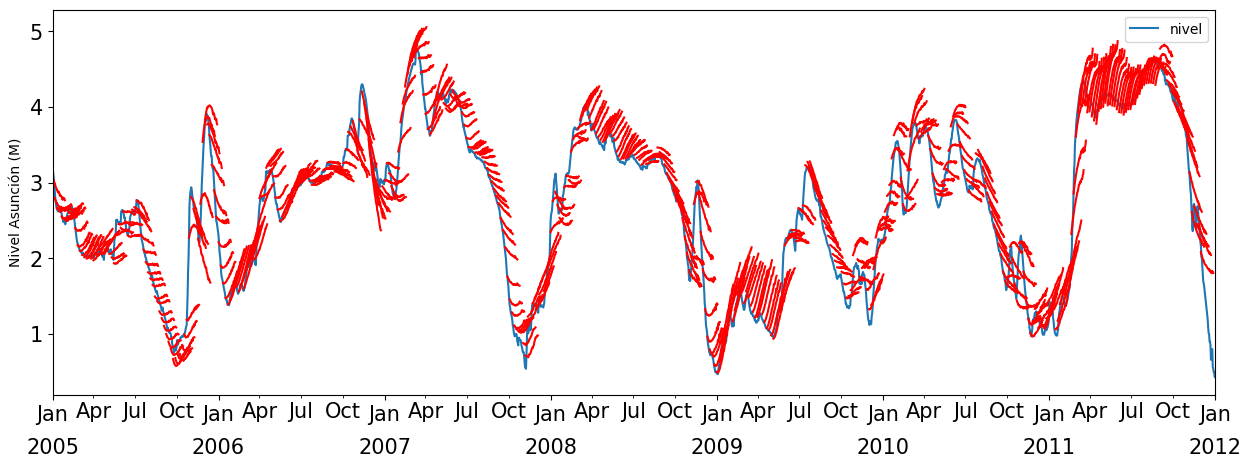

In [43]:

df = val[['nivel']][tamanio_ventana:]

# Se crea una figura f y el eje ax
f, ax = plt.subplots(figsize=(15, 5))

# Gráficos de líneas con datos de df y eje ax
sns.lineplot(data=df, ax=ax)

# Formato de fechas
# Objeto localizador coloca marcas menores cada 3 meses
fmt_month = mdates.MonthLocator(interval=3)
# Marcas cada año
fmt_year = mdates.YearLocator()

ax.xaxis.set_minor_locator(fmt_month)
# '%b' para obtener los nombres de los meses Muestra los meses como Ene, Feb ..
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(fmt_year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Tamaño de fuente de las etiquetas de marcas
ax.tick_params(labelsize=15, which='both')

# Crear un segundo eje x debajo del primero para mostrar el año en formato YYYY
sec_xaxis = ax.secondary_xaxis(-0.1)
sec_xaxis.xaxis.set_major_locator(fmt_year)
sec_xaxis.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Ocultar las líneas y marcas del segundo eje x
sec_xaxis.spines['bottom'].set_visible(False)
sec_xaxis.tick_params(length=0, labelsize=15)

ax.set_ylabel('Nivel Asunción (M)')
ax.set_xlabel('')
ax.set_xlim(df.index[0], df.index[-1])

j = 0
mse = []
maxe = []
t = []

# El bucle itera sobre los valores predichos (Y_prediction) con un paso de horizonte.
for i in range(0, len(Y_prediction), horizonte):
    if (j % 5 == 0) and ((j + horizonte) < len(df)):  # Si j es divisible por 5 calcula mse, maxErr de
        # Los valores reales de df.nivel[j:(j + horizonte)]) y valores predichos Y_prediction[i:i + horizonte]
        mse.append(mean_squared_error(np.array(df.nivel[j:(j + horizonte)]), Y_prediction[i:i + horizonte]))
        maxe.append(max_error(np.array(df.nivel[j:(j + horizonte)]), Y_prediction[i:i + horizonte]))
        t.append(df.index[j])
        
        plt.plot(df.index[j:(j + horizonte)], Y_prediction[i:i + horizonte], color='red')
    j += 1
plt.show()


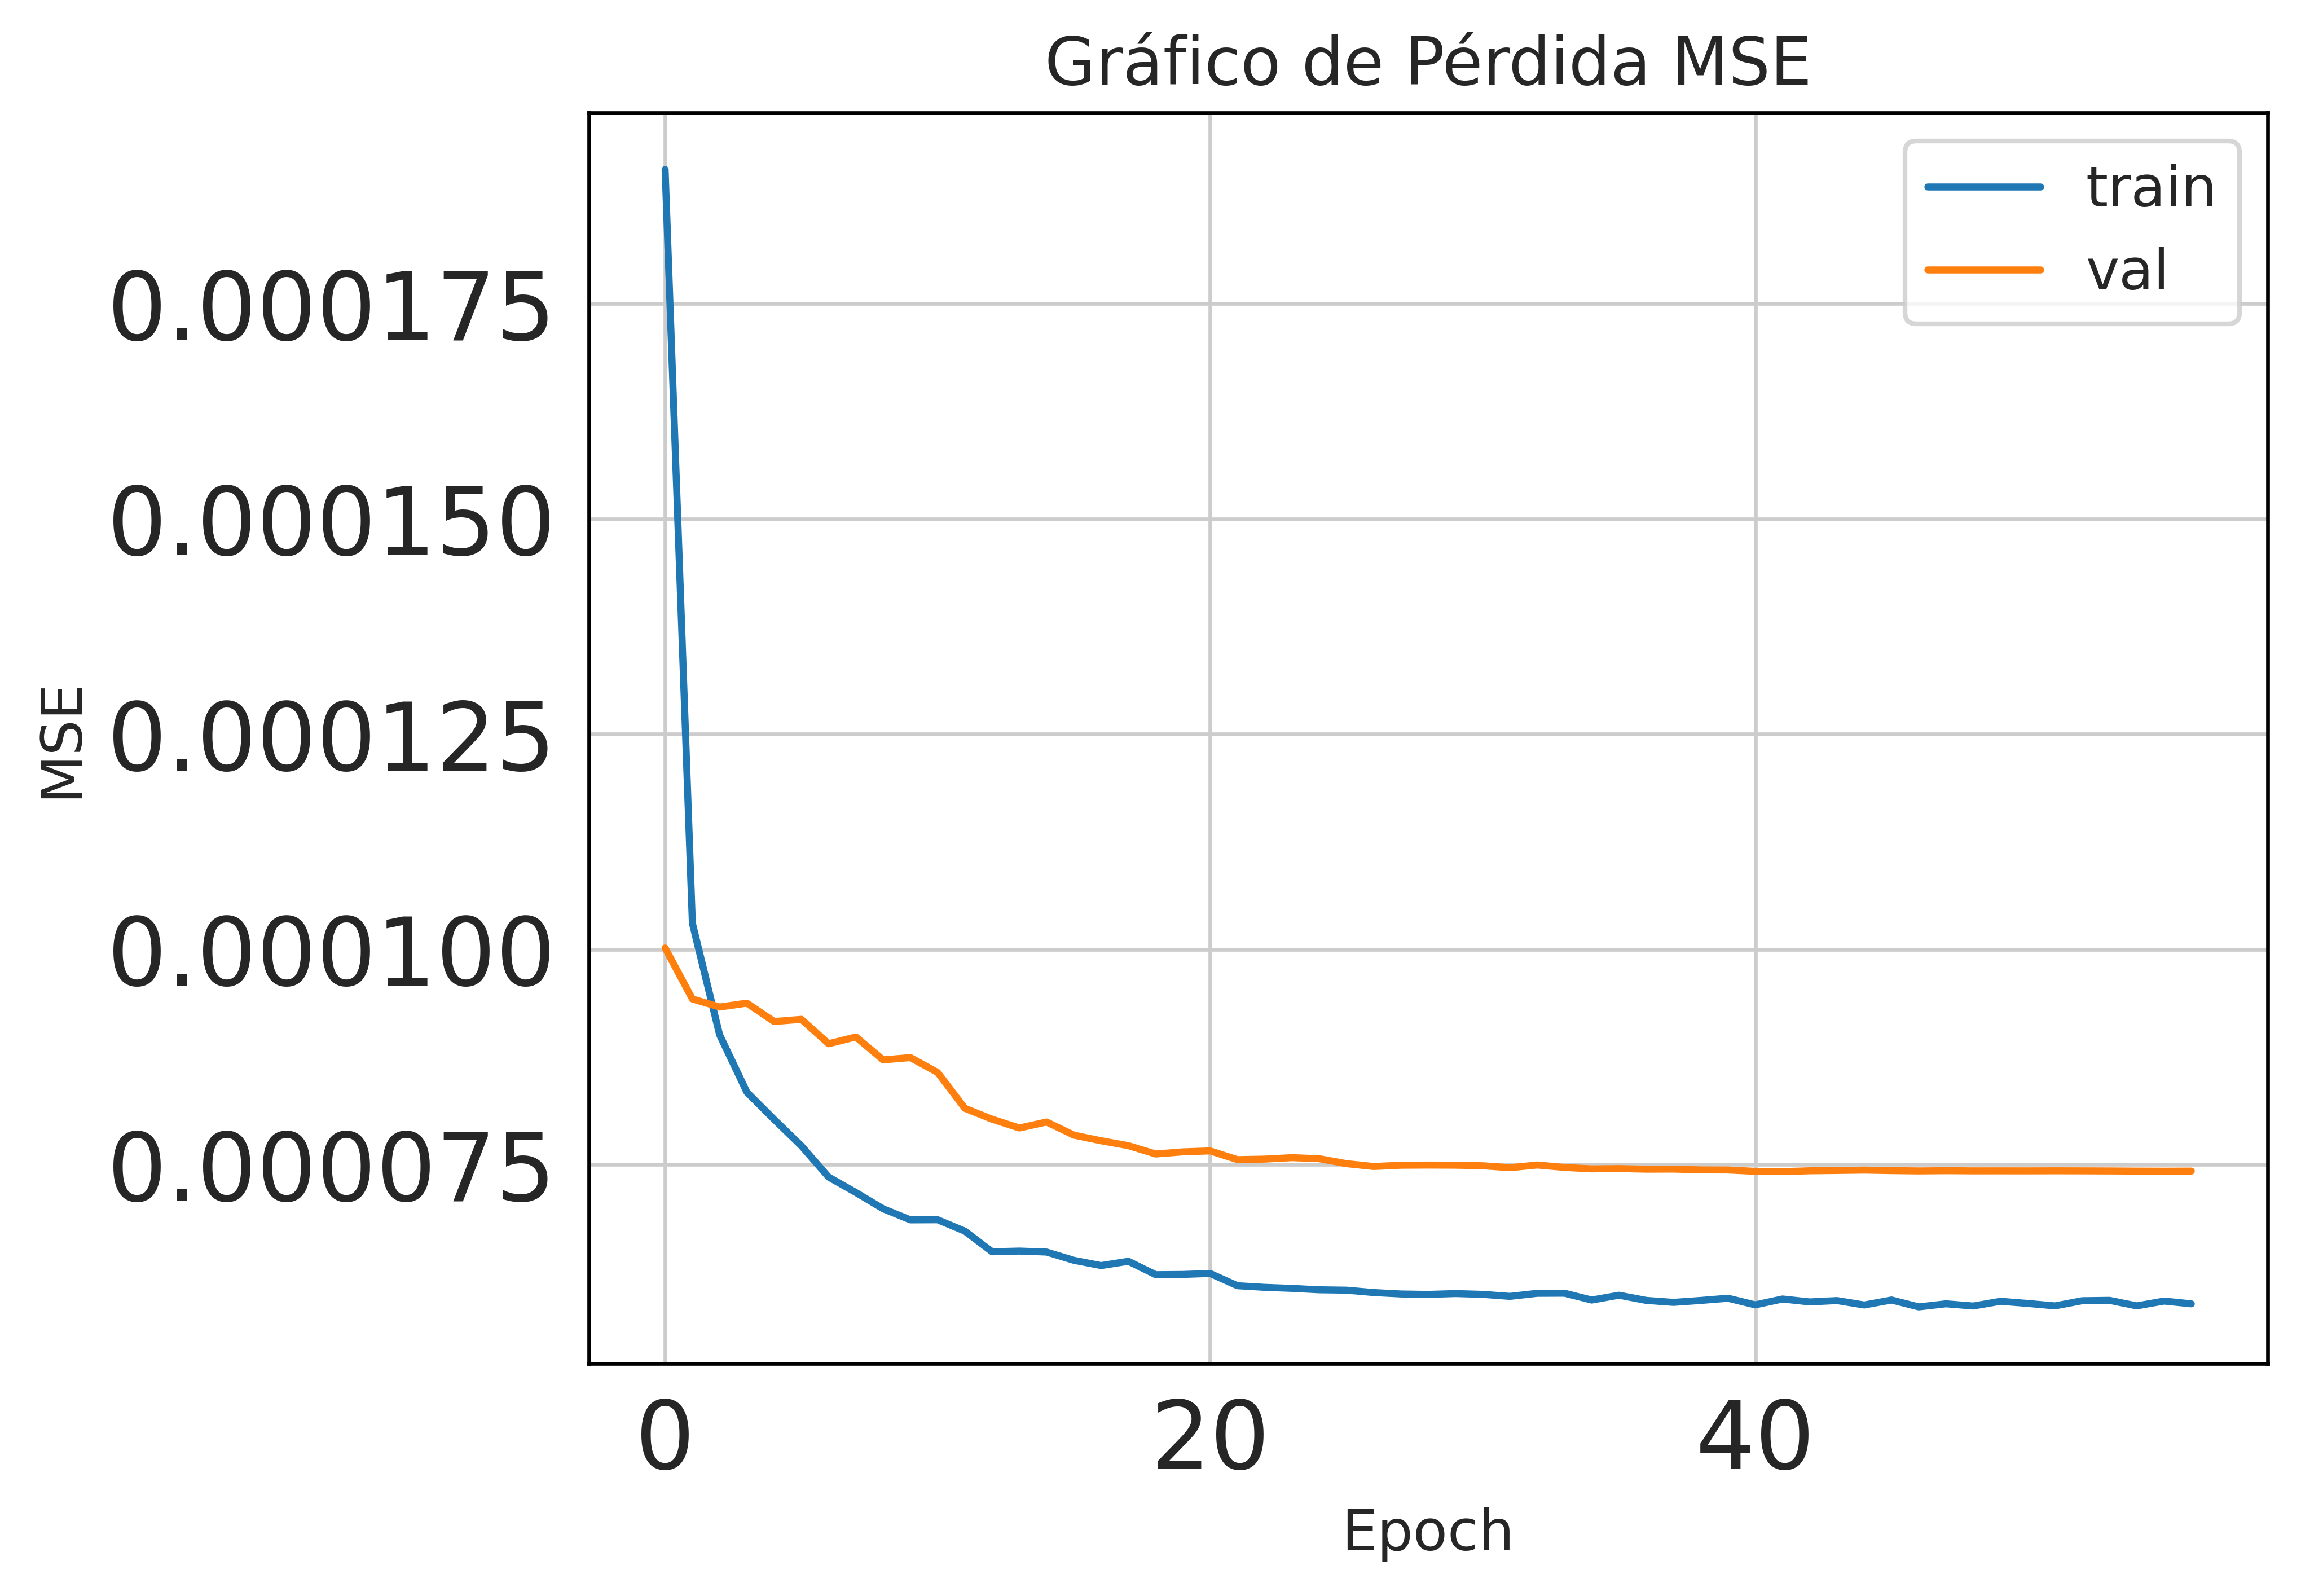

In [66]:
plt.rc('font', size=12)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Gráfico de Pérdida MSE', fontsize=14)  # Ajusta el tamaño del título
plt.ylabel('MSE', fontsize=12)  # Ajusta el tamaño del texto en el eje y
plt.xlabel('Epoch', fontsize=12)  # Ajusta el tamaño del texto en el eje x
plt.legend(['train', 'val'], loc='upper right', fontsize=12)  # Ajusta el tamaño de la leyenda
plt.show()

In [51]:
desde = (dt.datetime.strptime('2013-01-01', '%Y-%m-%d')- dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d') # Toma la fecha que se encuentra en el año '2018-01-01' hasta 'tamanio_ventana' días antes
test = datos_normm.loc[desde:'2022-01-01'] # Toma el conjunto de datos para la test
ix = test.index # Toma los indices del conjunto de datos de test
testScaler = RobustScaler()# Inicializa una normalización de 0 a 1 para el conjunto de datos de test
testScaler.fit(test) # Ajusta la normalización a los datos de test
testScaled = pd.DataFrame(testScaler.transform(test),columns=test.columns) # Crea un dataframe con el conjunto de datos de test normalizados y ajustados
testScaled.set_index(ix) # Agrega como indice la fecha al dataframe con los conjuntos de datos normalizados y ajustados
x_test, y_test = preparar_datos(tamanio_ventana,horizonte, testScaled) # Divide los datos de test

In [52]:
Y_prediction = testScaler.inverse_transform(np.hstack(((model.predict(x_test).reshape(-1, 1), np.zeros((np.size(y_test),nfeatures -1))))))[:, 0] # Predicción del modelo sobre los datos de test, y luego aplica una transformación inversa para delver los datos a su escala original
y_test_inv = testScaler.inverse_transform(np.hstack(((y_test.reshape(-1, 1), np.zeros((np.size(y_test),nfeatures -1))))))[:, 0] # Transformación inversa de 'y_test' a su escala original
mse = mean_squared_error( y_test_inv, Y_prediction) # Calculo del error cuadrático medio
mse = mean_squared_error( y_test_inv, Y_prediction) # Calculo del error cuadrático medio
rmse = np.sqrt(mse) # Calculo de la raíz del error cuadrático medio
maxError_ = max_error(y_test_inv, Y_prediction) # Error máximo entre y_test_inv e y y_prediction
r2_ = r2_score(y_test_inv, Y_prediction) # Calculo del coeficiente de determinación r cuadrado, que indica la proporción de la varianza en las etiquetas de test. Un valor cercano 1 indica un buen ajuste dell modelo 
nse = 1 - (np.sum((y_test_inv - Y_prediction) ** 2) / np.sum((y_test_inv - np.mean(y_test_inv)) ** 2)) # Cálculo de la metrica nse 
print( "MSE: " + str(mse)+" RMSE:" + str(rmse  )) # Muestra el MSE y RMSE
print( "MaxError: " + str(maxError_)+" R2:" + str(r2_  )) # Muestra maxError_ y R^2
print("NSE: " + str(nse)) # Muesta el NSE
end_time = time.time() # Registra el tiempo final desde la epoca
elapsed_time = end_time - start_time # Tiempo transcurrido entre epocas
print(f"Time step : {elapsed_time:.6f} seconds") # Muestra el tiempo transcurrido

102/102 [==============================] - 1s 13ms/step
MSE: 0.38873032987601447 RMSE:0.623482421465124
MaxError: 3.9810658841766418 R2:0.9047231270493141
NSE: 0.9047231270493141
Time step : 1855.644895 seconds


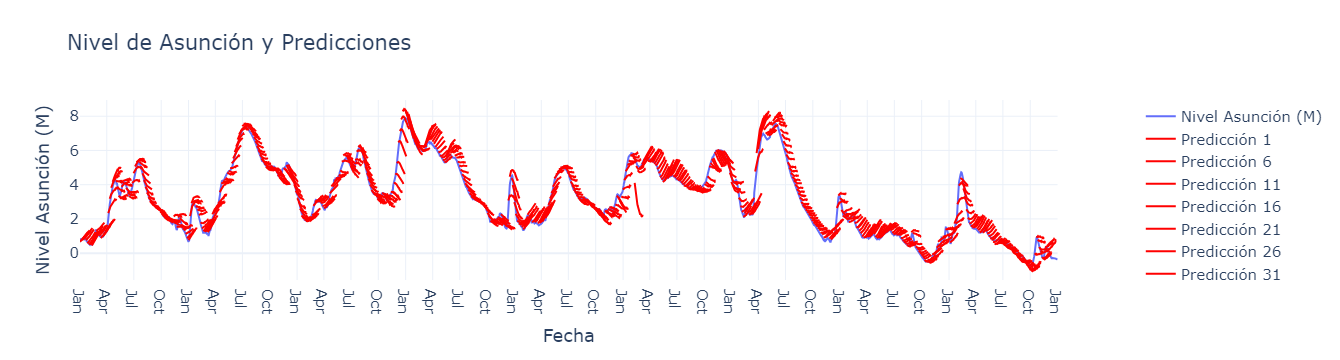

In [53]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from sklearn.metrics import mean_squared_error, max_error

# Definir el dataframe df y el conjunto de predicciones Y_prediction
# test = ... # Tu dataframe original
df = test[['nivel']][tamanio_ventana:]
# Y_prediction = ... # Tus predicciones
# horizonte = ... # El horizonte que estás usando para la predicción

# Crear figura con subplots para eje secundario
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Agregar línea de datos originales
fig.add_trace(go.Scatter(
    x=df.index, 
    y=df['nivel'], 
    mode='lines', 
    name='Nivel Asunción (M)'
))

# Bucle para agregar líneas de predicciones
j = 0
mse = []
maxe = []
t = []

for i in range(0, len(Y_prediction), horizonte):
    if (j % 5 == 0) and ((j + horizonte) < len(df)):
        mse.append(mean_squared_error(np.array(df['nivel'][j:(j + horizonte)]), Y_prediction[i:i + horizonte]))
        maxe.append(max_error(np.array(df['nivel'][j:(j + horizonte)]), Y_prediction[i:i + horizonte]))
        t.append(df.index[j])

        fig.add_trace(go.Scatter(
            x=df.index[j:(j + horizonte)], 
            y=Y_prediction[i:i + horizonte], 
            mode='lines', 
            line=dict(color='red'), 
            name=f'Predicción {i//horizonte + 1}'
        ), secondary_y=False)
    j += 1

# Actualizar layout de la figura
fig.update_layout(
    title='Nivel de Asunción y Predicciones',
    xaxis_title='Fecha',
    yaxis_title='Nivel Asunción (M)',
    xaxis=dict(
        tickformat="%b",  # Formato de los meses
        tickmode='linear',
        dtick="M3"  # Cada 3 meses
    ),
    xaxis2=dict(
        tickformat="%Y",  # Formato del año
        overlaying='x',
        side='bottom',
        position=0.1,
        ticklen=0,
        showline=False
    ),
    template='plotly_white',
    font=dict(size=15)
)

# Mostrar figura
fig.show()

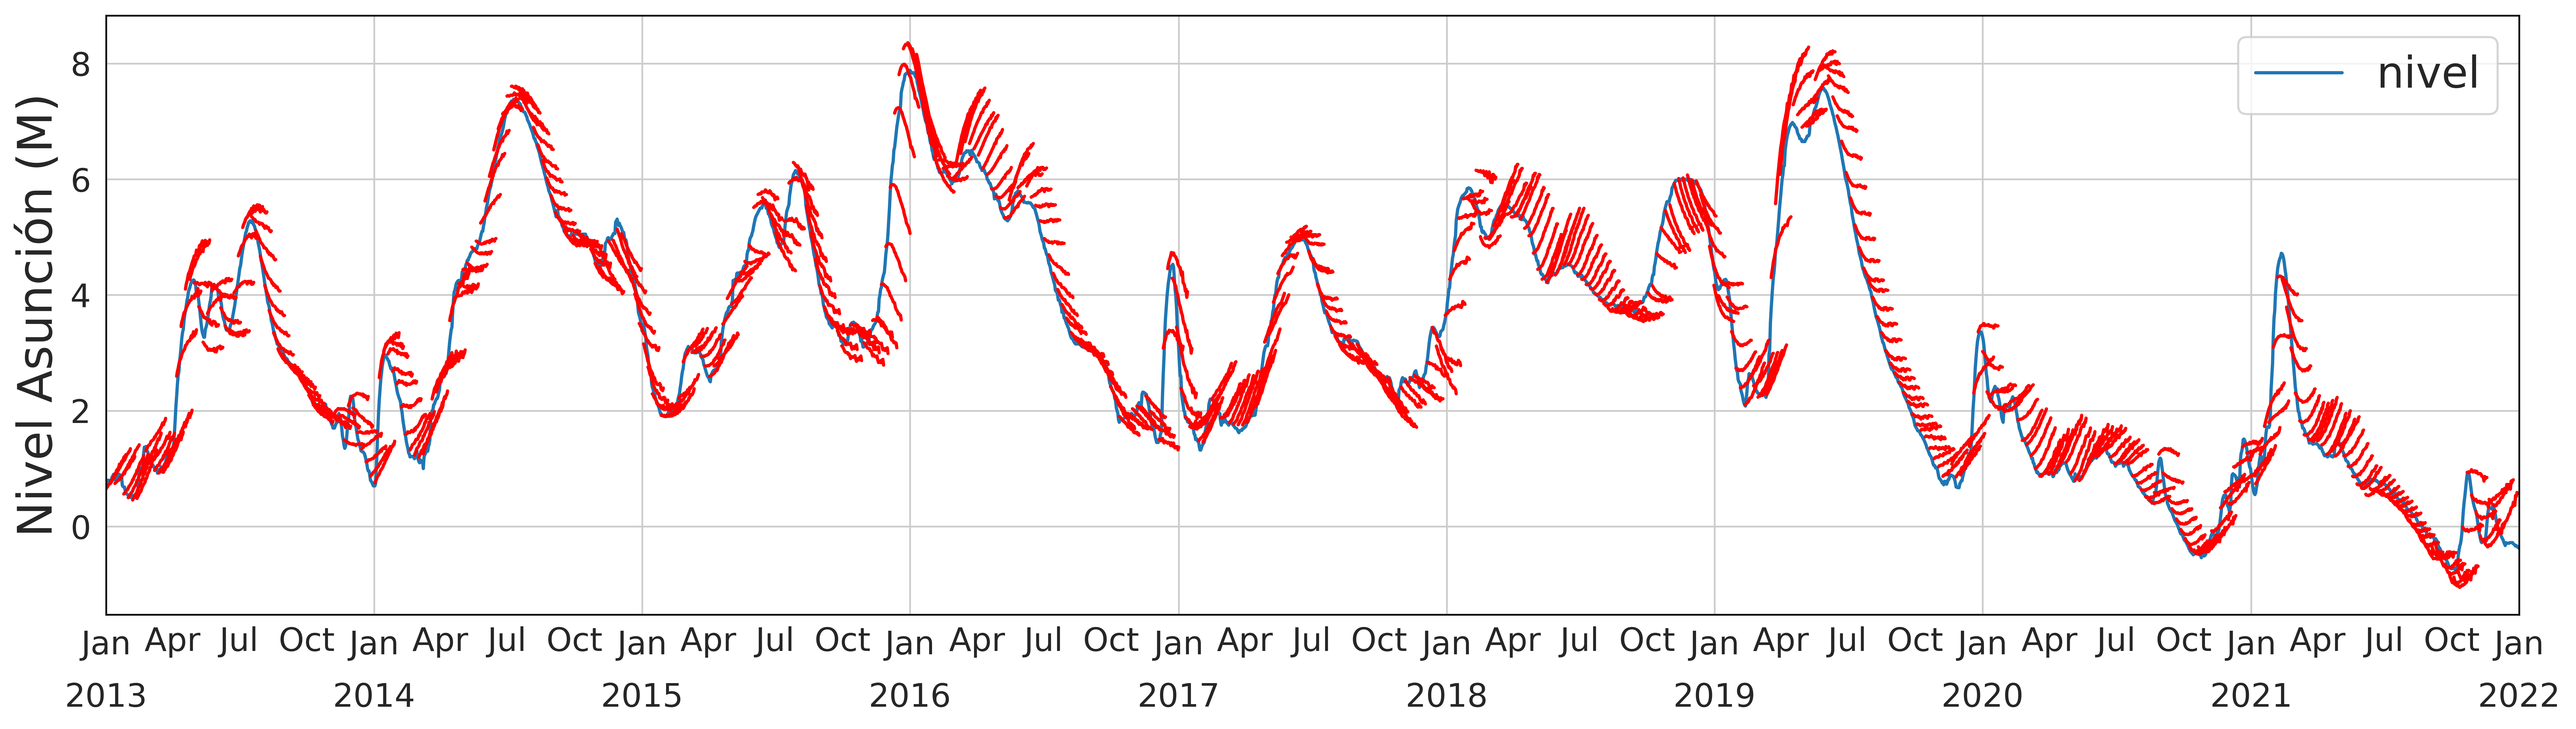

In [62]:
df = test[['nivel']][tamanio_ventana:]

# Se crea una figura f y el eje ax
f, ax = plt.subplots(figsize=(20, 5))

# Gráficos de líneas con datos de df y eje ax
sns.lineplot(data=df, ax=ax)

# Formato de fechas
# Objeto localizador coloca marcas menores cada 3 meses
fmt_month = mdates.MonthLocator(interval=3)
# Marcas cada año
fmt_year = mdates.YearLocator()

ax.xaxis.set_minor_locator(fmt_month)
# '%b' para obtener los nombres de los meses Muestra los meses como Ene, Feb ..
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(fmt_year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Tamaño de fuente de las etiquetas de marcas
ax.tick_params(labelsize=15, which='both')

# Crear un segundo eje x debajo del primero para mostrar el año en formato YYYY
sec_xaxis = ax.secondary_xaxis(-0.1)
sec_xaxis.xaxis.set_major_locator(fmt_year)
sec_xaxis.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Ocultar las líneas y marcas del segundo eje x
sec_xaxis.spines['bottom'].set_visible(False)
sec_xaxis.tick_params(length=0, labelsize=15)

ax.set_ylabel('Nivel Asunción (M)')
ax.set_xlabel('')
ax.set_xlim(df.index[0], df.index[-1])

j = 0
mse = []
maxe = []
t = []

# El bucle itera sobre los valores predichos (Y_prediction) con un paso de horizonte.
for i in range(0, len(Y_prediction), horizonte):
    if (j % 6 == 0) and ((j + horizonte) < len(df)):  # Si j es divisible por 5 calcula mse, maxErr de
        # Los valores reales de df.nivel[j:(j + horizonte)]) y valores predichos Y_prediction[i:i + horizonte]
        mse.append(mean_squared_error(np.array(df.nivel[j:(j + horizonte)]), Y_prediction[i:i + horizonte]))
        maxe.append(max_error(np.array(df.nivel[j:(j + horizonte)]), Y_prediction[i:i + horizonte]))
        t.append(df.index[j])
        
        plt.plot(df.index[j:(j + horizonte)], Y_prediction[i:i + horizonte], color='red')
    j += 1
plt.show()

In [57]:
# Guardar el estudio
with open("optuna_study2.pkl", "wb") as f:
   dump(study, f)

# Cargar el estudio
with open("optuna_study2.pkl", "rb") as f:
    study = load(f)

In [58]:
import seaborn as sns
import pandas as pd
import datetime as dt
import numpy as np
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as dates
from matplotlib import dates as mdates
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,max_error
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 300
rcParams["font.size"] = 16
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
sns.set_style("whitegrid")
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
import optuna
from pickle import dump,load

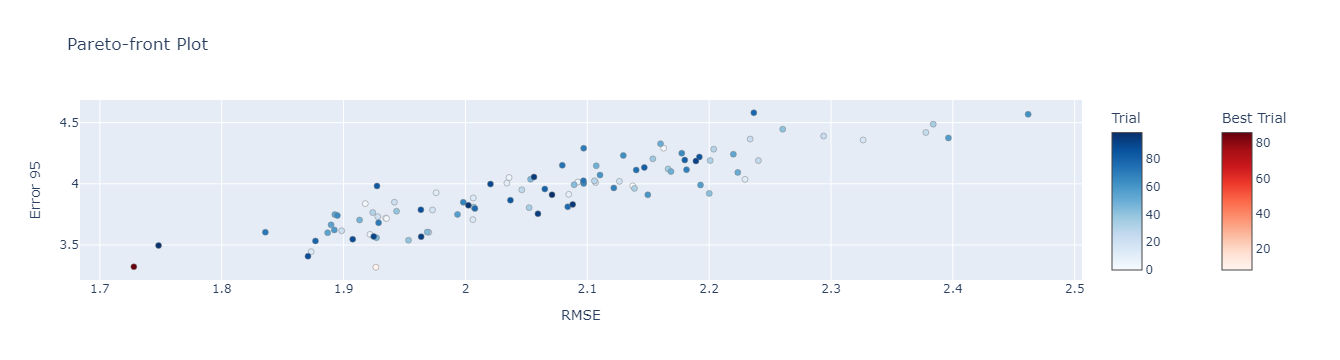

In [59]:
# Cargar el estudio de Optuna
study = load(open('optuna_study2.pkl', 'rb'))

# Visualizar el frente de Pareto
fig = optuna.visualization.plot_pareto_front(study, target_names=["RMSE", "Error 95"])
fig.show()

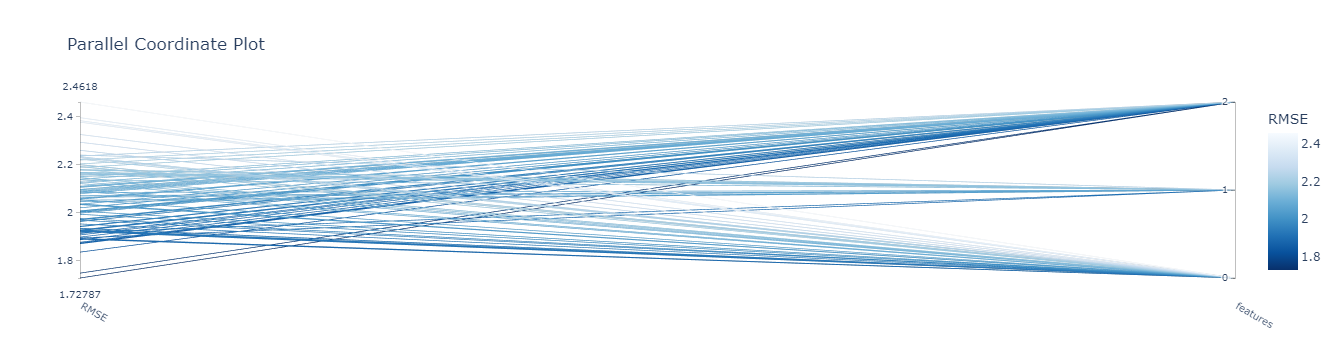

In [60]:
# Visualizar la importancia de los parámetros
#fig_param_importances = optuna.visualization.plot_param_importances(study,target=target, target_name="RMSE")
#fig_param_importances.show()
# Función para determinar el objetivo
def target(trial):
    return trial.values[0]  # Puedes cambiar el índice para el segundo objetivo si deseas

# Visualizar la coordenada paralela con el objetivo especificado
fig_parallel_coordinate = optuna.visualization.plot_parallel_coordinate(study, target=target, target_name="RMSE")
fig_parallel_coordinate.show()